# Unsupervised Deep Embedding Clustering for Zooniverse

Use the approach from [Unsupervised Deep Embedding for Clustering Analysis](https://arxiv.org/abs/1511.06335). I'm using the keras implementation [here](https://github.com/XifengGuo/DEC-keras).

The algorithm uses greedy layer-wise pretaining of a [deep denoising autoencoder](https://blog.keras.io/building-autoencoders-in-keras.html) to learn an initial embedding that minimises reconstruction loss.  Clusters are then initialised using K-means.  Training examples (subjects) are then encoded by the auto encoder and assigned to clusters by a soft assignment based on proximity to a cluster centre.  The network parameters and cluster centres are then further trained by minimising the KL divergence between the soft cluster assignments and an auxiliary distribution.  The auxiliary distribution assumes that those examples lying closest to a cluster centre have a high confidence of belonging to the same class (or at least share some relationship that is worth reinforcing).  The auxiliary distribution also normalises the loss contribution of each centroid such that the loss is not completely dominated by the largest centroids.

Applying this to Zooniverse.

#### Experiment 1 - Exploring DEC

- ##### Experiment 1a
Run the MNIST experiment from the original paper.  This is our completely unsupervised benchmark.  The clusters currently have no meaning.

- ##### Experiment 1b
Try different training set sizes.  The original paper uses the entire 70000 MNIST data set.  We should experiment with how varying the size of the initial training affects performance.  For some of our experiments we will need a test set, so we should at least hold out the 10000 MNIST test set subjects reducing the training set size to 60000 subjects.  

- ##### Experiment 1c
Experiment with the number of clusters we use.  The paper uses 10 clusters but this is based on prior knowledge of the data set.  Using many more clusters will produce smaller but purer clusters with the trade-off that they require more human input.
  - ##### Aside
  With K-means each cluster must have subjects assigned to it by definition, DEC does not enforce any such constraint.  For example when using 100 clusters for the MNIST data set a few clusters are left empty.  This will cause problems when we want to create many clusters to assign to many volunteers.  There are a few possible solutions
    - Do nothing and simply divide the cluster into smaller chunks and assign those to volunteers.
    - Update the DEC cost function to penalise empty clusters.  Since unassigned clusters are probably telling us something about our data, this will likely be akin to the above.  However, the hope would be that the clusters still capture at least some information about the structure of the data.
    - Don't bother fine-tuning the network with the auxillary distribution.  Train the SAEs, initialise K-means and then query volunteers for labels for subjects.  The volunteer classifications can then be used to train the network online.
    - Query volunteers for labels based on the uncertainty in the cluster assignment.  The soft cluster assignments can be used as a proxy for the uncertainty.  We can ask for more fine grained classifications of the most uncertain subjects and ask for classifications of batches of subjects close to the cluster mean.

- ##### Experiment 1d
Experiment with including the test set during the DEC training phase and not including it.  The former replicates the scenario where a Zooniverse project has all the data they want to classify upfront.  The latter is the case where we expect new data to be continually added to the project and can't include that data while training DEC.

#### Experiment 2 - incorportating citizen scientists

- ##### Experiment 2a
Simulate querying cluster labels from volunteers for the clustering in experiment 1. This is simply done by assigning the majority cluster class to to each cluster.

- ##### Experiment 2b
Design an architecture that allows the network to be trained using both the auxillary distribution and the labels provided by volunteers.  This is likely to take the form of a mapping layer that is tagged onto the end of DEC mapping the clusters to labels.

- ##### Experiment 2c
Train the network with the MNIST labels.  This replicates querying labels from perfect classifiers for every subject in the MNIST data set.  In this case we simulate crowd sourcing the cluster labels (Experiment 2a) and then crowd sourcing labels for every subject in the data set to identify misclassified subjects that can be used to further refine the learned feature space.

- ##### Experiment 2d
Are cluster assignments still meaningful or retireveable after the network has been retrained on queried labels.  In other words does our supervised optimisation continue to update the cluster centres.  This is what I want to happen and it is important to understand if it is actually happening.

- ##### Experiment 2e
Experiment with differing levels of volunteer classification noise.

- ##### Experiment 2f
How many labelled examples do we need to update the classifier.

- ##### Experiment 2g
Try to find more efficient methods for identifying misclassified subjects.  We want to do better than simply querying labels for every subject in the data set as done in Experiment 2c.

#### Experiment 3 - application to a real data set
Repeat experiment 1 and 2 for Supernova Hunters data.

- ##### Experiment 3c
Experiment with different numbers of clusters.

#### Experiment 4 - application to natural images using weel known data sets
Repeat experiment 1 and 2 for CIFAR-10, CIFAR-100 and STL-10 datasets.  These are more similar to ecology projects.  STL-10 in particular might be interesting as there are only 500 training images and 800 test images  per class but has 100000 unlabelled images.  Might be interesting to test serendipitous discovery and the presence of uninteresting classes.  We could also test transfer learning between data sets.

#### Experiment 5 - application to ecology projects
Repeat experiment 1 and 2 but with Marcos Ecology Project data set.

#### Experiment 6 - using a pretrained CNN to replace stacked denoising autoencoders
Use Marcos pretrained CNN to replace the deep autoencoder in experiment 1.  This investigates transfer learning applied to our clustering approach to gathering labels.

#### Experiment 7 - using a pretrained model for multiple projects across disciplines
Take a publicly available pretrained model, strip off the classification layer and append the clustering layer and apply it to multiple Zooniverse porjects across disciplines.  This takes transfer learning to the extreme but results from the Pan-STARRS1 give me hope that this is not as crazy as it seems.

#### Experiment 8 - designing a system to dissolve clusters
How can the idea of dissolving clusters be incorporated into the network architecture.  Should we just 'delete' that cluster in which case all its members will be assigned to their next best cluster? Should we just randomly reinitialise the cluster (this runs the risk of undoing earlier training)? Should we divide the cluster into 2 new clusters with the new cluster centres initialised based on some information we have about where different classes lie within the original cluster.

## Setup

In [1]:
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import rcParams
from time import time

In [2]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda
from keras.initializers import Initializer
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.engine.topology import Layer
from keras import backend as K

Using TensorFlow backend.


In [3]:
np.random.seed(0)

Import the DEC implementation and various helper functions from the DEC-keras repository.

In [4]:
sys.path.insert(0,'../DEC-keras/')

In [5]:
from DEC import DEC, ClusteringLayer, cluster_acc

## Experiment 1
### Experiment 1a - replicate results of original DEC paper

Load the mnist data set normalised as in the DEC paper.

In [6]:
from datasets import load_mnist

In [427]:
x, y = load_mnist()

MNIST samples (70000, 784)


Define some contants from the paper.

In [8]:
n_clusters = 10 # this is chosen based on prior knowledge of classes in the data set.
batch_size = 256
lr         = 0.01 # learning rate
momentum   = 0.9
tol        = 0.001 # tolerance - if clustering stops if less than this fraction of the data changes cluster on an interation

Define some constants for this implementation

In [9]:
maxiter         = 2e4
update_interval = 140
save_dir         = '../DEC-keras/results/'

In [10]:
# prepare the DEC model
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)

I have already run the greedy layer-wise pretraining so tell DEC where to find those weights. 

In [11]:
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'

In [12]:
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x)

Display a summary of the model archietecture.

In [13]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110.0
Trainable params: 1,665,110.0
Non-trainable params: 0.0
____________________________________________________________

In [14]:
try:
  dec.load_weights('../DEC-keras/results/mnist/10/DEC_model_final.h5')
  y_pred = dec.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec.clustering(x, y=y, tol=tol, maxiter=maxiter,
                          update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

acc: 0.874085714286


The above gives our unsupervised benchmark accuracy of 87.40% on the entire MNIST data set (70000 subjects).  For a Zooniverse project we would have no idea what this value is unless, for some reason, we have labels for every subject upfront.  We may have a smaller sample of labelled data that can give us an estimate of the unsupervised performance but with some unknown error.

### Experiment 1b - training set sizes

I have trained DEC on training set sizes in the range 100-60000.  I will measure the unsupervised accuracy on these using the entire data set of 70000 subjects.  This represents the case where we have a limited data set at the start of a Zooniverse project with which to train DEC, but then use DEC to cluster new data unseen by DEC during training.

In [15]:
training_set_sizes = [100, 500, 1000, 5000, 10000, 50000]
path_to_weights = '../experiments/Unsupervised_Deep_Embedding_Clustering_for_Zooniverse/experiment1b'

In [16]:
accs = []
tmp_dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
for training_set_size in training_set_sizes:
  tmp_dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights=path_to_weights+'/ae_weights_m%d.h5'%training_set_size,
                       x=x)
  tmp_dec.load_weights(path_to_weights+'/results/dec/%d'%(training_set_size)+'/DEC_model_final.h5')
  tmp_y_pred = tmp_dec.predict_clusters(x)
  acc = cluster_acc(y, tmp_y_pred)
  accs.append(acc)
  print('acc:', acc)
accs.append(0.874085714286) # add the performance of training on all 70000 subjects
training_set_sizes.append(70000)

acc: 0.481814285714
acc: 0.542085714286
acc: 0.454742857143
acc: 0.661014285714
acc: 0.778542857143
acc: 0.852642857143


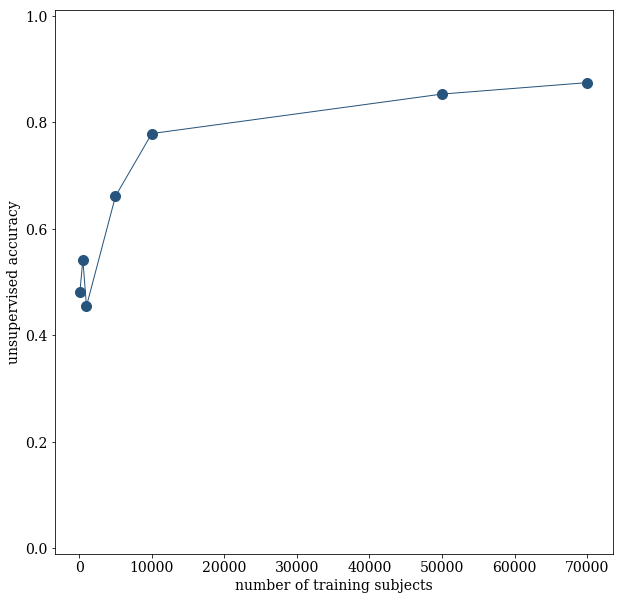

In [17]:
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 14
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(training_set_sizes, accs, 'o', color='#26547C', ms=10)
ax.plot(training_set_sizes, accs, '-', color='#26547C', lw=1)
#ax.set_xticks(training_set_sizes)
ax.set_ylim(-0.01,1.01)
ax.set_xlabel('number of training subjects')
ax.set_ylabel('unsupervised accuracy')
plt.show()

### Experiment 1c - number of clusters

In [86]:
save_dir = '../DEC-keras/results/mnist/100'
n_clusters=100
# prepare the DEC model
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'
## passing 'kld' and None as loss to dec.initialize_model work.
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x)
dec.model.summary()
try:
  dec.load_weights(save_dir + '/DEC_model_final.h5')
  y_pred = dec.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec.clustering(x, y=y, tol=tol, maxiter=maxiter,
                          update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,666,010.0
Trainable params: 1,666,010.0
Non-trainable params: 0.0
____________________________________________________________

In [207]:
def get_cluster_to_label_mapping(y, y_pred, n_classes, n_clusters):

  one_hot_encoded = np_utils.to_categorical(y, n_classes)

  cluster_to_label_mapping = [] # will be a mapping from the cluster index to the label assigned to that cluster
  n_assigned_list = []
  majority_class_fractions = []
  majority_class_pred = np.zeros(y.shape)
  for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_assigned_list.append(n_assigned_examples)
    cluster_labels = one_hot_encoded[cluster_indices]
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    majority_cluster_class = np.argmax(cluster_label_fractions)
    cluster_to_label_mapping.append(majority_cluster_class)
    majority_class_pred[cluster_indices] += majority_cluster_class
    majority_class_fractions.append(cluster_label_fractions[majority_cluster_class])
    print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
  print(cluster_to_label_mapping)
  return cluster_to_label_mapping, n_assigned_list, majority_class_fractions

In [88]:
cluster_to_label_mapping, n_assigned_list, _ = get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=100)

0 82 6 0.768292682927
1 1218 1 0.995073891626
2 326 3 0.929447852761
3 923 0 0.98374864572
4 305 7 0.950819672131
5 470 7 0.874468085106
6 1624 4 0.987684729064
7 1325 5 0.972830188679
8 502 3 0.998007968127
9 1566 9 0.915070242656
10 1294 1 0.993044822257
11 1043 0 0.968360498562
12 2049 8 0.971205466081
13 950 6 0.992631578947
14 58 2 0.810344827586
15 258 2 0.848837209302
16 440 3 0.934090909091
17 1888 3 0.969809322034
18 547 4 0.946983546618
19 30 2 0.966666666667
20 984 7 0.983739837398
21 426 0 0.99765258216
22 326 5 0.858895705521
23 9 6 0.333333333333
24 404 0 0.925742574257
25 528 5 0.922348484848
26 1096 5 0.984489051095
27 1322 0 0.983358547655
28 2592 8 0.947916666667
29 56 3 0.839285714286
30 895 1 0.964245810056
31 1306 8 0.981623277182
32 899 6 0.982202447164
33 642 9 0.964174454829
34 2389 3 0.984930933445
35 15 8 0.866666666667
36 1370 6 0.989781021898
37 485 9 0.898969072165
38 1001 1 0.998001998002
39 3 8 1.0
40 1432 1 0.980446927374
41 35 2 0.571428571429
42 33 4 0

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


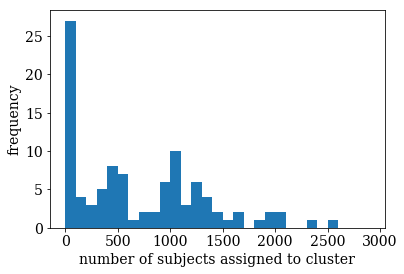

In [34]:
bins = range(0,3000,100)
plt.hist(n_assigned_list, bins=bins)
plt.ylabel('frequency')
plt.xlabel('number of subjects assigned to cluster')
plt.show()

### Aside - unassigned clusters
#### updating the cost function

We will add a penalty term to the KL-divergence cost that increases as the number of subjects assigned to each cluster diverges from 1/k, where k is the number of clusters.

In [35]:
def custom_kld_with_penalty(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  kld = K.sum(y_true * K.log(y_true / y_pred), axis=-1)
  
  ro = K.cast(K.tile([1 / K.shape(y_true)[0]], [K.shape(y_true)[1]]), 'float64')
  ro_j = K.cast(K.sum(y_pred, axis=0) / K.tile([K.cast(K.shape(y_true)[0], 'float32')], [K.shape(y_true)[1]]), 'float64')
    
  penalty = K.sum((ro * K.log(ro / ro_j)) + (1. - ro) * K.log((1. - ro) / (1. - ro_j)), axis=-1)
  return kld + K.cast(penalty, 'float32')

In [36]:
save_dir = '../DEC-keras/results/testing/mnist/100'
n_clusters=100
# prepare the DEC model
dec_custom_loss = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'
## passing 'kld' and None as loss to dec.initialize_model work.
dec_custom_loss.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x, loss=custom_kld_with_penalty)
dec_custom_loss.model.summary()
try:
  dec_custom_loss.load_weights(save_dir + '/DEC_model_final.h5')
  y_pred = dec_custom_loss.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_custom_loss.clustering(x, y=y, tol=tol, maxiter=maxiter,
                          update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,666,010.0
Trainable params: 1,666,010.0
Non-trainable params: 0.0
____________________________________________________________

In [37]:
cluster_to_label_mapping, n_assigned_list, _ = get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=100)

0 123 9 0.422764227642
1 792 1 0.940656565657
2 810 5 0.975308641975
3 895 0 0.997765363128
4 887 1 0.995490417136
5 598 8 0.483277591973
6 920 5 0.939130434783
7 568 3 0.975352112676
8 634 7 0.854889589905
9 941 6 0.989373007439
10 696 1 0.995689655172
11 650 2 0.990769230769
12 626 6 0.982428115016
13 762 4 0.975065616798
14 260 5 0.565384615385
15 908 2 0.875550660793
16 651 2 0.615975422427
17 542 5 0.852398523985
18 774 8 0.996124031008
19 768 1 1.0
20 572 7 0.912587412587
21 878 0 0.993166287016
22 234 6 0.880341880342
23 552 0 0.91847826087
24 765 4 0.98954248366
25 795 3 0.97358490566
26 1509 7 0.983432736912
27 612 6 0.975490196078
28 845 6 0.994082840237
29 1111 1 0.999099909991
30 663 8 0.930618401207
31 756 5 0.993386243386
32 825 7 0.966060606061
33 547 3 0.970749542962
34 697 9 0.979913916786
35 696 5 0.847701149425
36 1562 9 0.993597951344
37 709 6 0.98730606488
38 910 8 0.961538461538
39 1087 1 0.509659613615
40 847 4 0.978748524203
41 523 1 0.984703632887
42 772 0 0.98

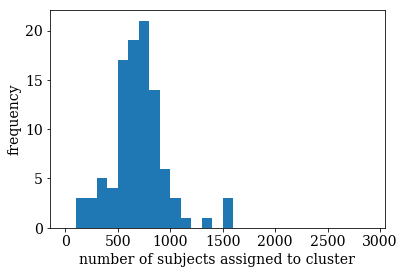

In [38]:
bins = range(0,3000,100)
counts,_,_ = plt.hist(n_assigned_list, bins=bins)
plt.ylabel('frequency')
plt.xlabel('number of subjects assigned to cluster')
plt.show()

#### leveraging the soft cluster assignments

In [489]:
save_dir = '../DEC-keras/results/mnist/100' # use the original cost function
n_clusters=100
# prepare the DEC model
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'
## passing 'kld' and None as loss to dec.initialize_model work.
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x, loss='kld')
dec.model.summary()
try:
  dec.load_weights(save_dir + '/DEC_model_final.h5')
  y_pred = dec.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec.clustering(x, y=y, tol=tol, maxiter=maxiter,
                          update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,666,010.0
Trainable params: 1,666,010.0
Non-trainable params: 0.0
____________________________________________________________

In [490]:
cluster_to_label_mapping, n_assigned_list, _ = get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=100)

0 82 6 0.768292682927
1 1218 1 0.995073891626
2 326 3 0.929447852761
3 923 0 0.98374864572
4 305 7 0.950819672131
5 470 7 0.874468085106
6 1624 4 0.987684729064
7 1325 5 0.972830188679
8 502 3 0.998007968127
9 1566 9 0.915070242656
10 1294 1 0.993044822257
11 1043 0 0.968360498562
12 2049 8 0.971205466081
13 950 6 0.992631578947
14 58 2 0.810344827586
15 258 2 0.848837209302
16 440 3 0.934090909091
17 1888 3 0.969809322034
18 547 4 0.946983546618
19 30 2 0.966666666667
20 984 7 0.983739837398
21 426 0 0.99765258216
22 326 5 0.858895705521
23 9 6 0.333333333333
24 404 0 0.925742574257
25 528 5 0.922348484848
26 1096 5 0.984489051095
27 1322 0 0.983358547655
28 2592 8 0.947916666667
29 56 3 0.839285714286
30 895 1 0.964245810056
31 1306 8 0.981623277182
32 899 6 0.982202447164
33 642 9 0.964174454829
34 2389 3 0.984930933445
35 15 8 0.866666666667
36 1370 6 0.989781021898
37 485 9 0.898969072165
38 1001 1 0.998001998002
39 3 8 1.0
40 1432 1 0.980446927374
41 35 2 0.571428571429
42 33 4 0

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [491]:
q = dec.model.predict(x) # get the soft cluster assignments

In [492]:
print(np.max(q))
print(np.mean(q))
print(np.std(q))

0.915706
0.01
0.0738875


In [507]:
def cluster_partitioning(cluster, cluster_to_label_mapping, q, y_pred, y, x, image_dim, step=0.05, limit=100):
  label = cluster_to_label_mapping[cluster]
  print('Cluster label : %d' % label)
  mask = np.where(np.argmax(q, axis=1) == cluster)
  plt.hist(np.squeeze(q[:,cluster]), normed=True, alpha=.9)
  plt.hist(np.squeeze(q[mask,cluster]), normed=True, alpha=.9)
  plt.ylabel('normailised counts')
  plt.xlabel('q[:,%d]'%cluster)
  plt.show()
  y_pred_masked = y_pred[mask]
  y_masked = y[mask]
  x_masked = x[mask]
  accs = []
  for start in np.arange(0,1, step):
    mask2 = np.squeeze(q[mask,cluster] >= start) == np.squeeze(q[mask,cluster] < start+step)
    y_pred_double_masked = y_pred_masked[mask2]
    y_double_masked = y_masked[mask2]
    x_double_masked = x_masked[mask2]
    accs.append(np.mean(y_double_masked == label))
    print('%.3lf < q[:,%d] <= %.3lf'%(start, cluster, start+step))
    if len(mask2) == 0:
      continue
    plotCluster(y_pred_double_masked, cluster, x_double_masked, 28, limit=100)
  plt.plot(np.arange(0,1, step), accs, 'o', color='#26547C', ms=10)
  plt.plot(np.arange(0,1, step), accs, '-', color='#26547C', ms=1)
  plt.xlabel('q[:,%d]'%(cluster))
  plt.ylabel('accuracy')
  plt.show()

Cluster label : 8


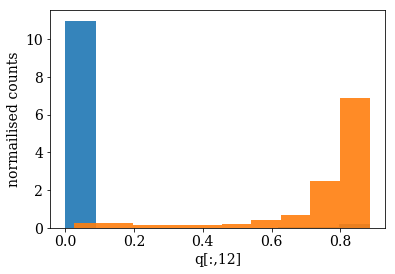

0.000 < q[:,12] <= 0.050
11


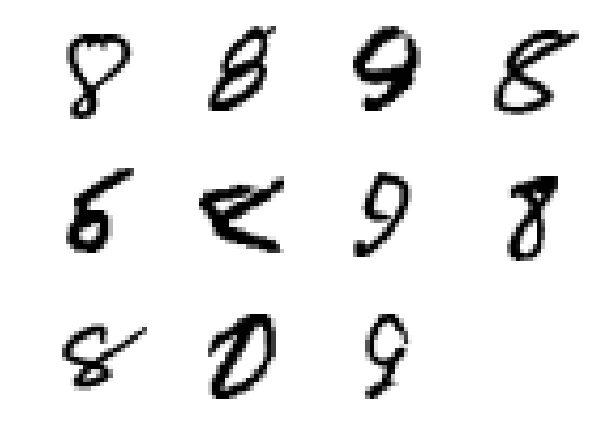

0.050 < q[:,12] <= 0.100
27


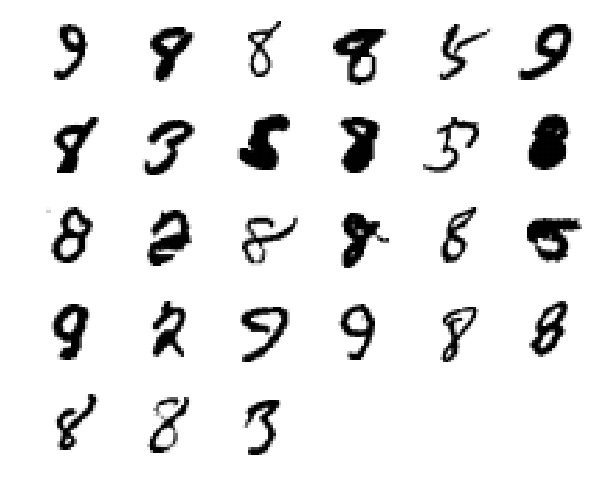

0.100 < q[:,12] <= 0.150
23


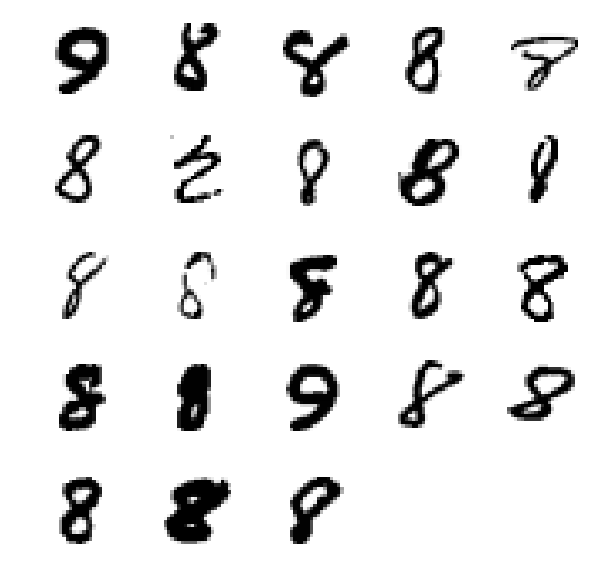

0.150 < q[:,12] <= 0.200
25


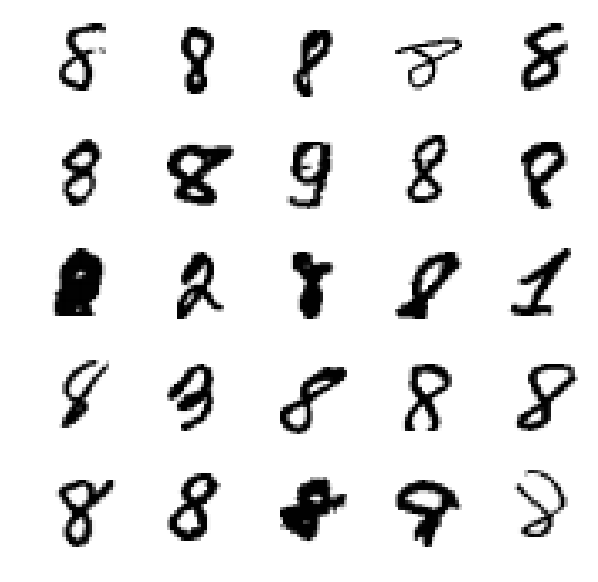

0.200 < q[:,12] <= 0.250
14


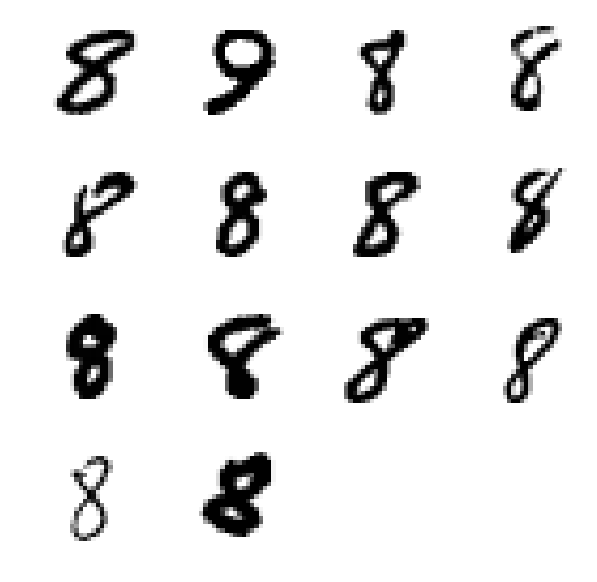

0.250 < q[:,12] <= 0.300
16


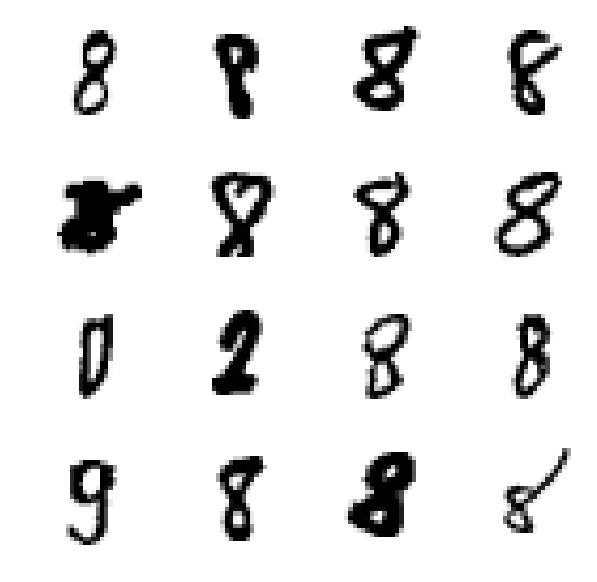

0.300 < q[:,12] <= 0.350
11


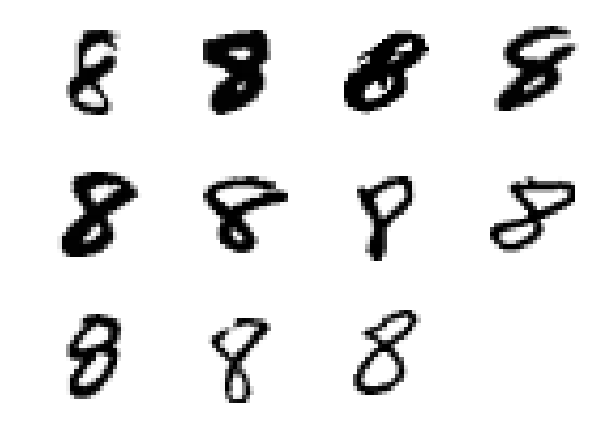

0.350 < q[:,12] <= 0.400
12


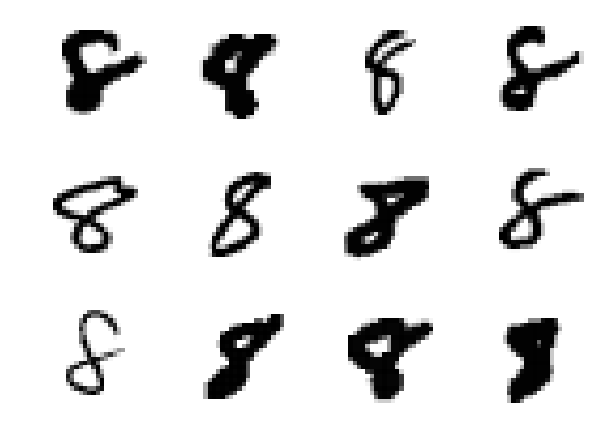

0.400 < q[:,12] <= 0.450
20


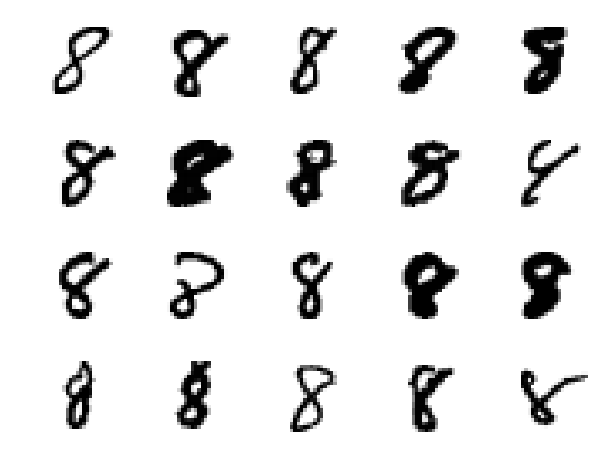

0.450 < q[:,12] <= 0.500
16


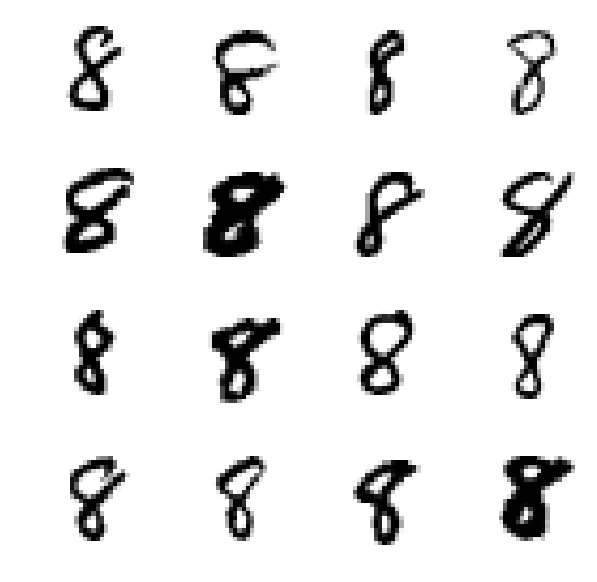

0.500 < q[:,12] <= 0.550
28


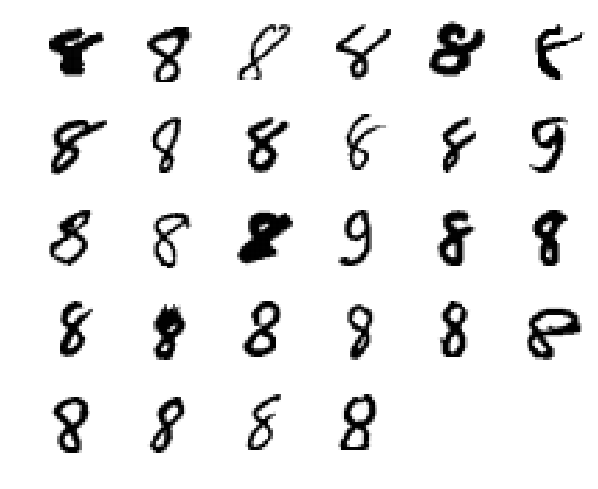

0.550 < q[:,12] <= 0.600
41


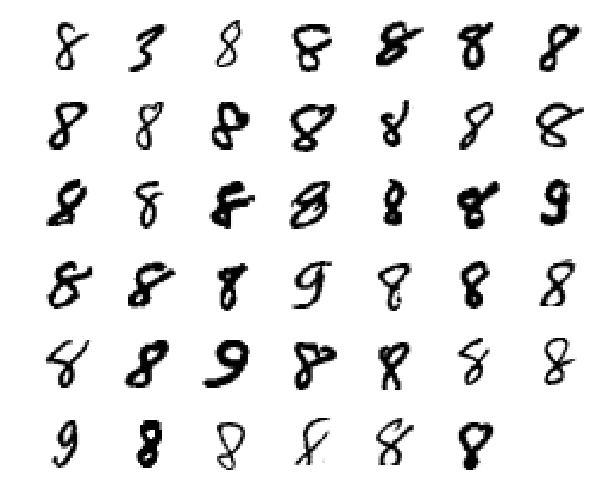

0.600 < q[:,12] <= 0.650
57


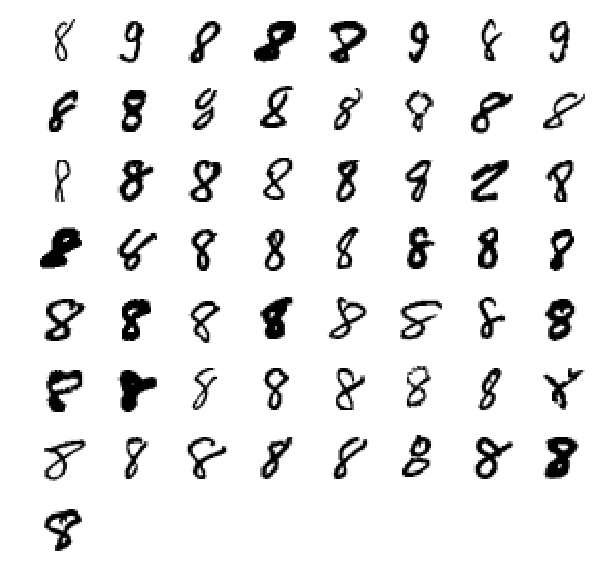

0.650 < q[:,12] <= 0.700
70


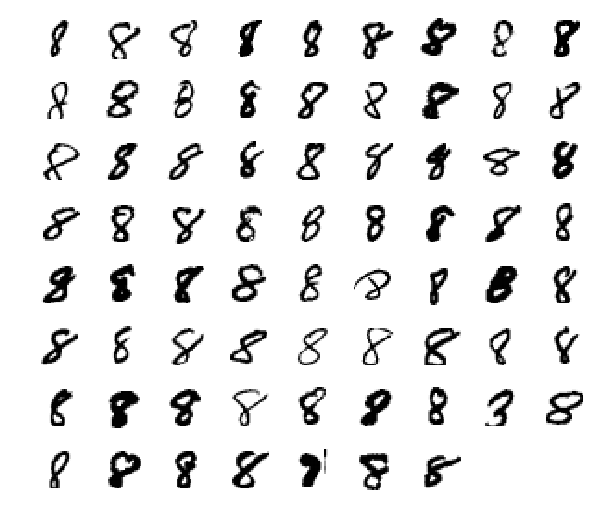

0.700 < q[:,12] <= 0.750
135


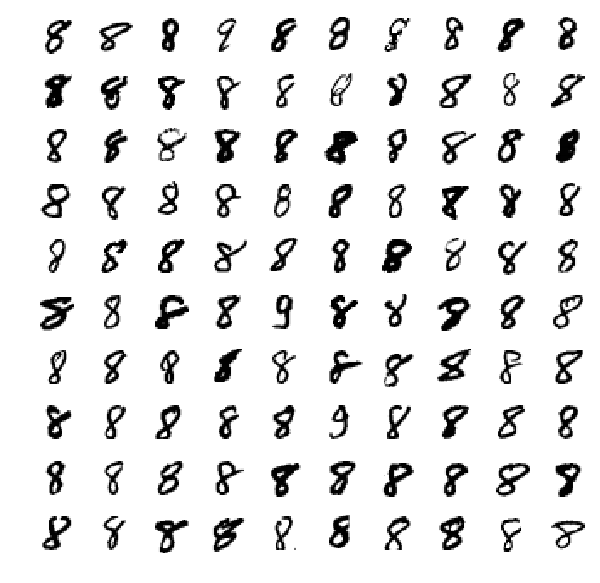

0.750 < q[:,12] <= 0.800
337


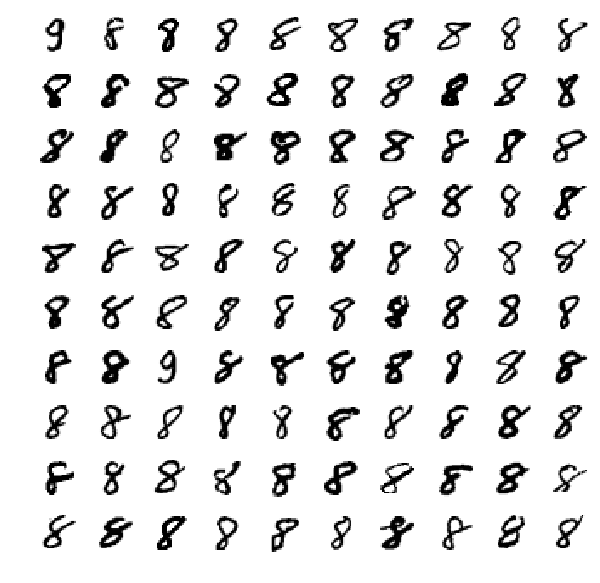

0.800 < q[:,12] <= 0.850
859


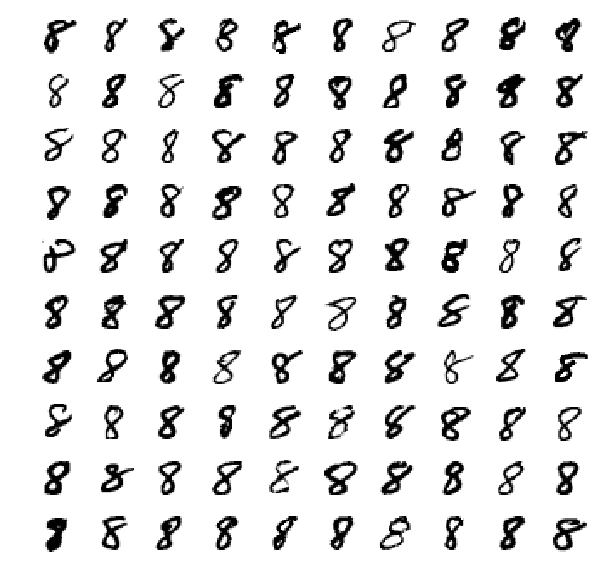

0.850 < q[:,12] <= 0.900
347


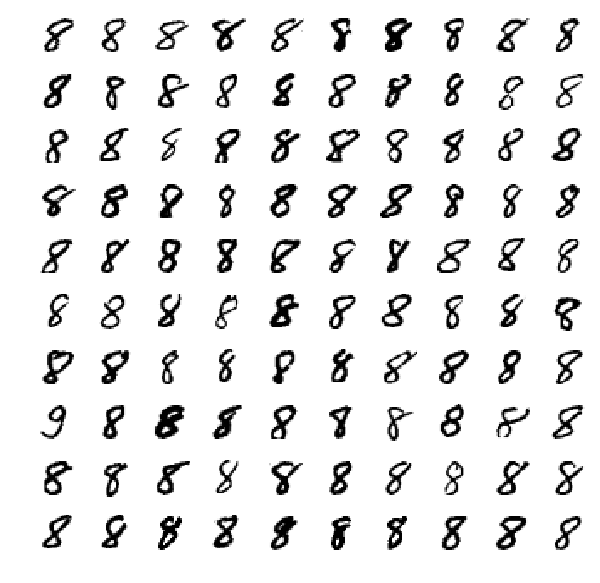

0.900 < q[:,12] <= 0.950
0


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.950 < q[:,12] <= 1.000
0


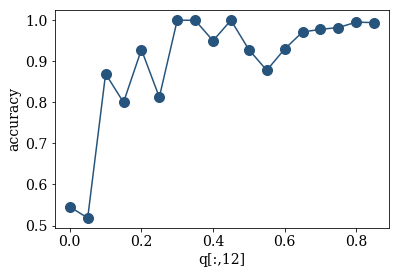

In [508]:
cluster_partitioning(12, cluster_to_label_mapping, q, y_pred, y, x, 28, step=0.05, limit=100)

Cluster label : 9


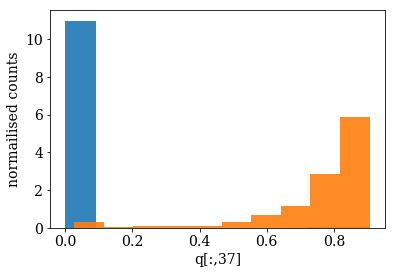

0.000 < q[:,37] <= 0.050
2


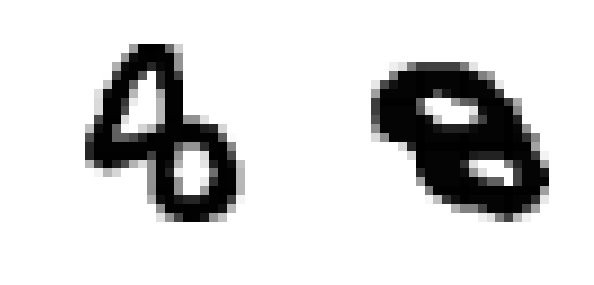

0.050 < q[:,37] <= 0.100
8


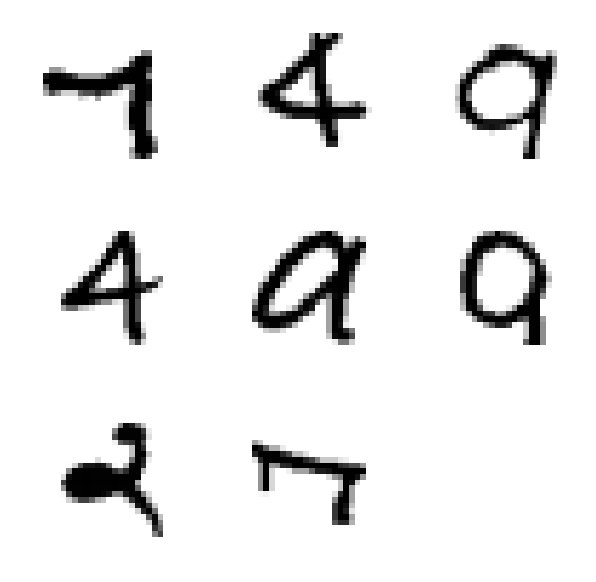

0.100 < q[:,37] <= 0.150
2


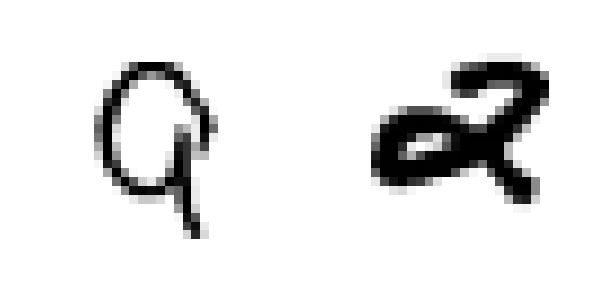

0.150 < q[:,37] <= 0.200
1


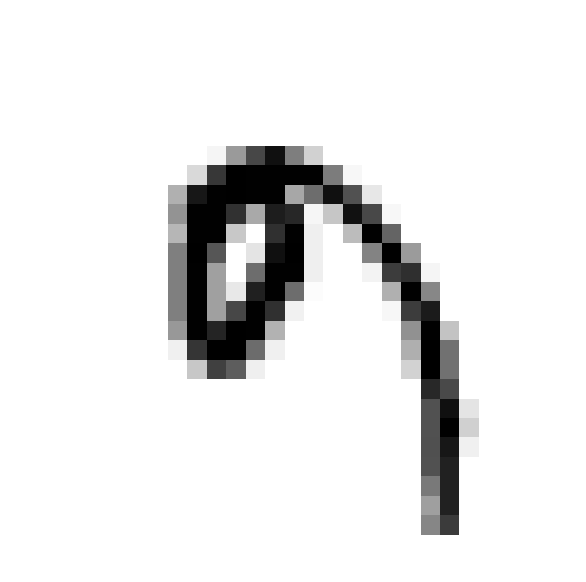

0.200 < q[:,37] <= 0.250
4


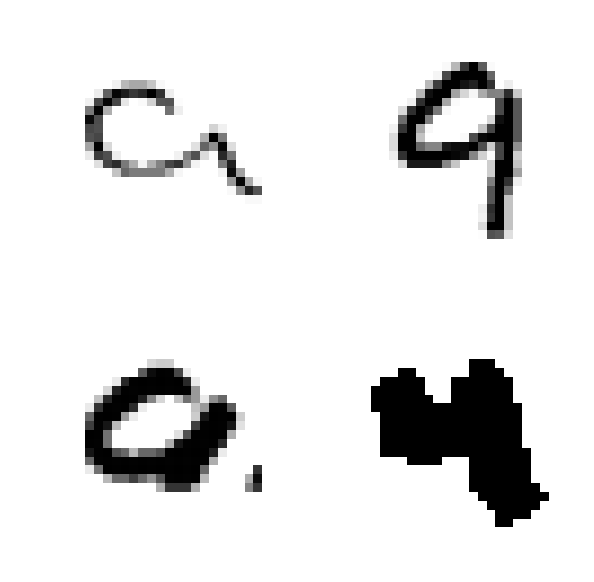

0.250 < q[:,37] <= 0.300
0


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.300 < q[:,37] <= 0.350
3


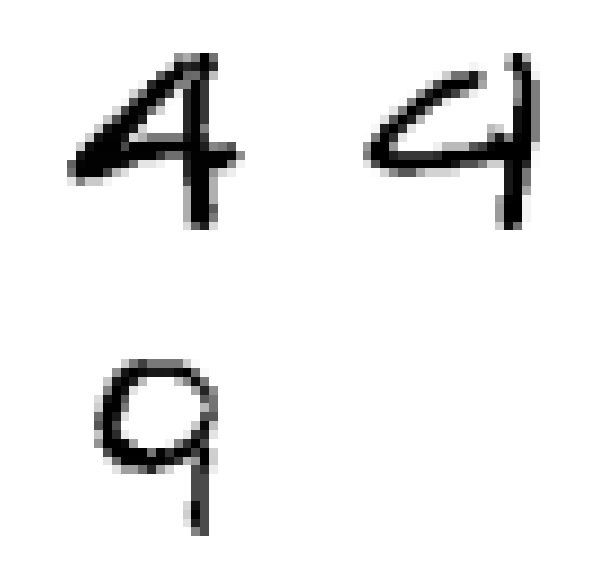

0.350 < q[:,37] <= 0.400
1


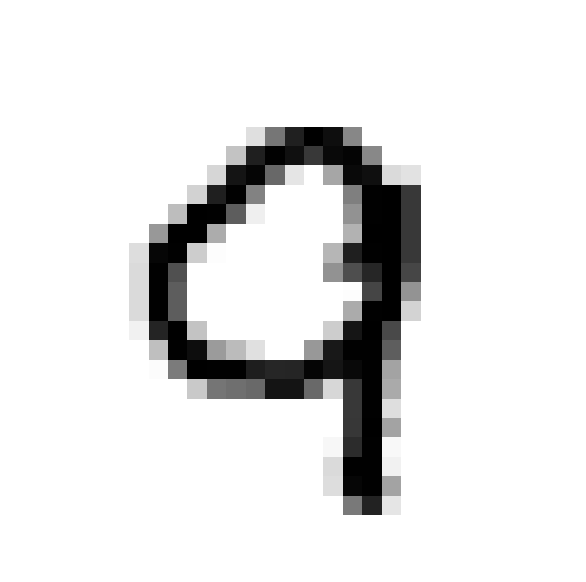

0.400 < q[:,37] <= 0.450
4


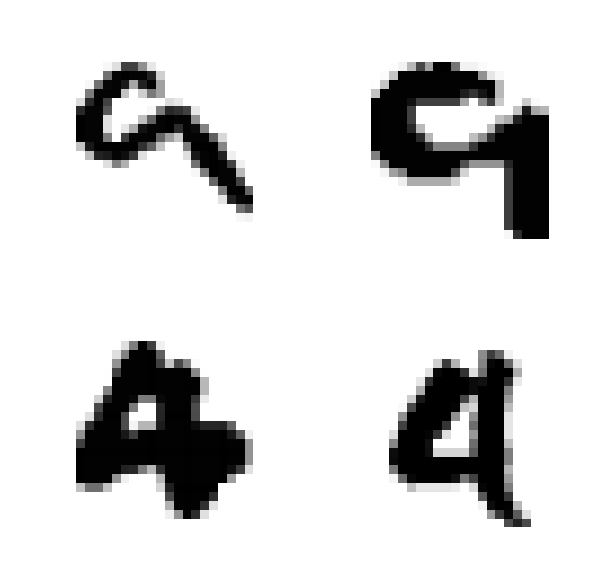

0.450 < q[:,37] <= 0.500
8


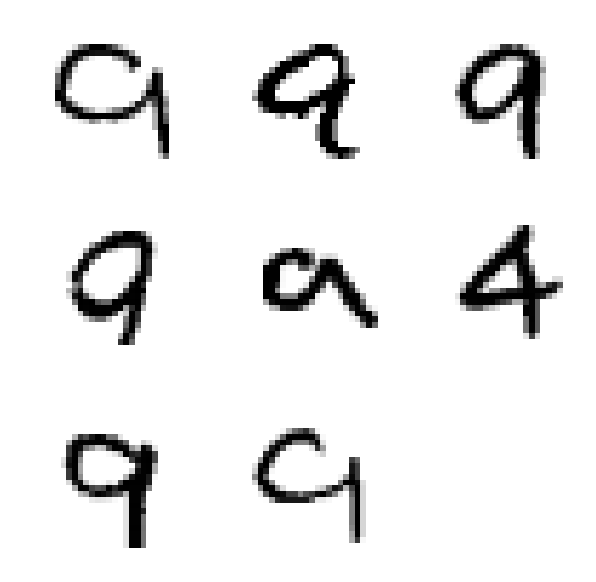

0.500 < q[:,37] <= 0.550
4


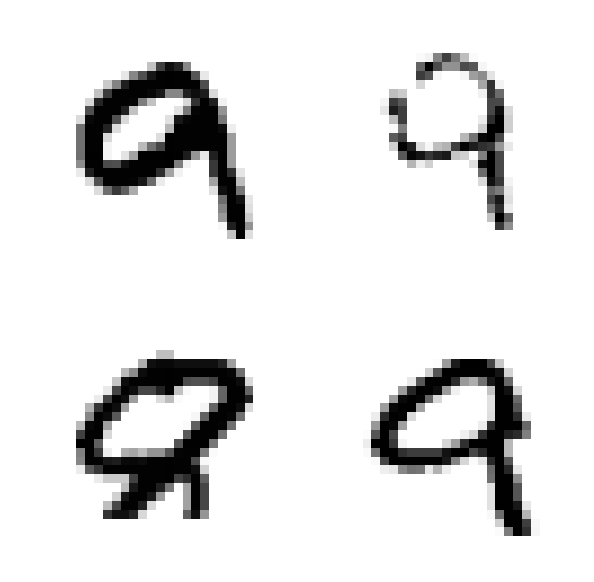

0.550 < q[:,37] <= 0.600
13


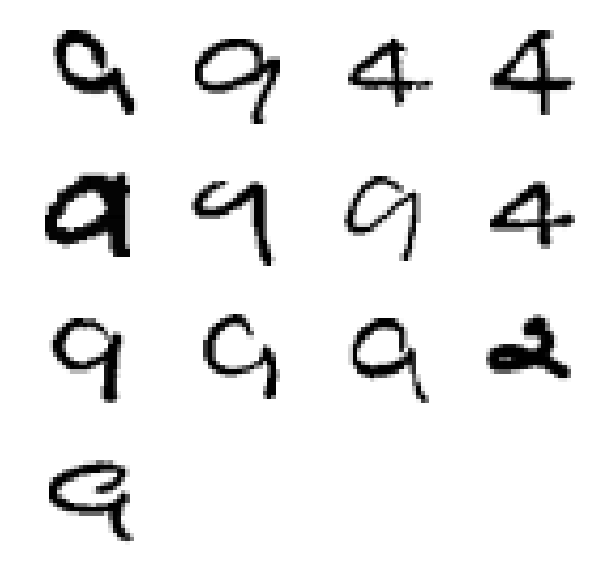

0.600 < q[:,37] <= 0.650
17


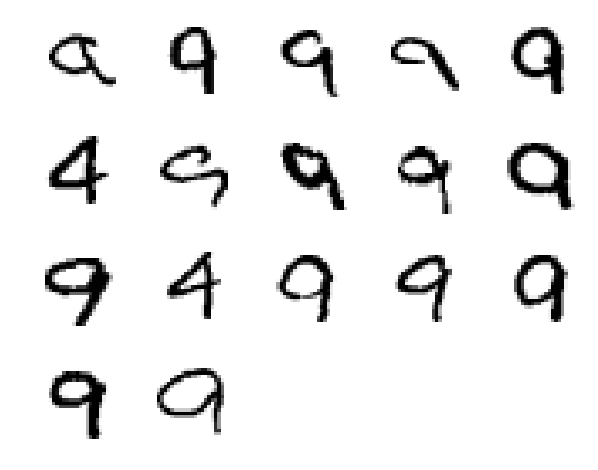

0.650 < q[:,37] <= 0.700
23


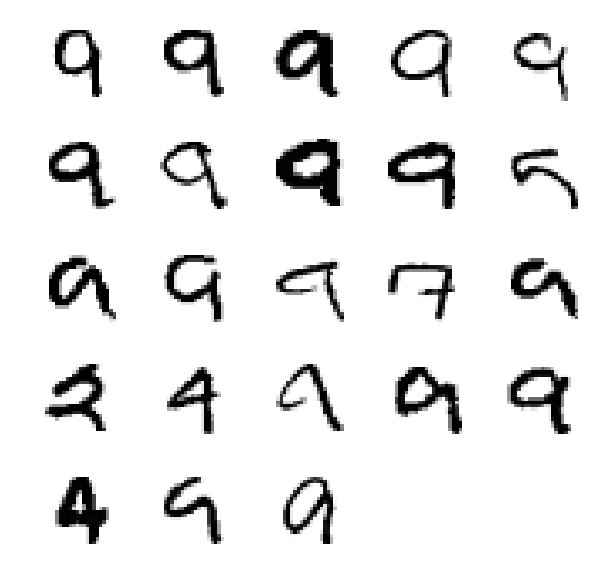

0.700 < q[:,37] <= 0.750
41


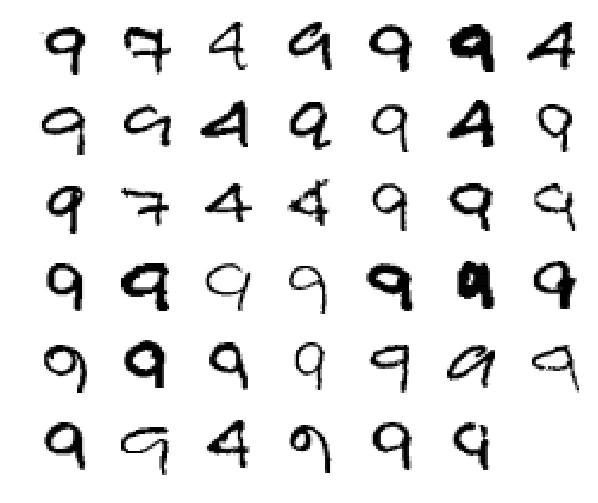

0.750 < q[:,37] <= 0.800
76


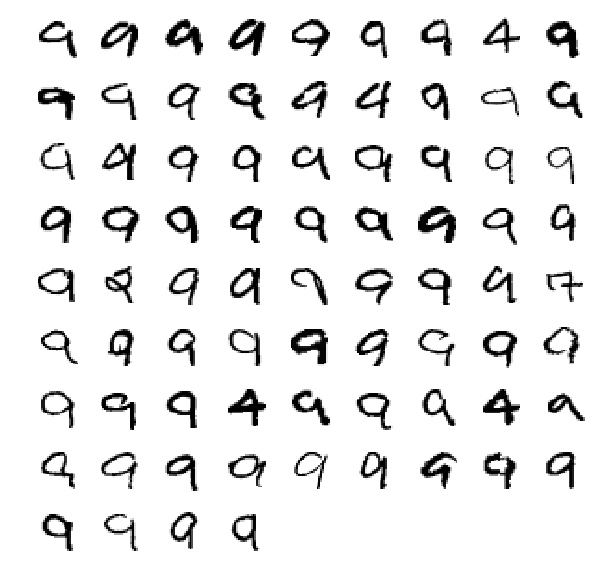

0.800 < q[:,37] <= 0.850
112


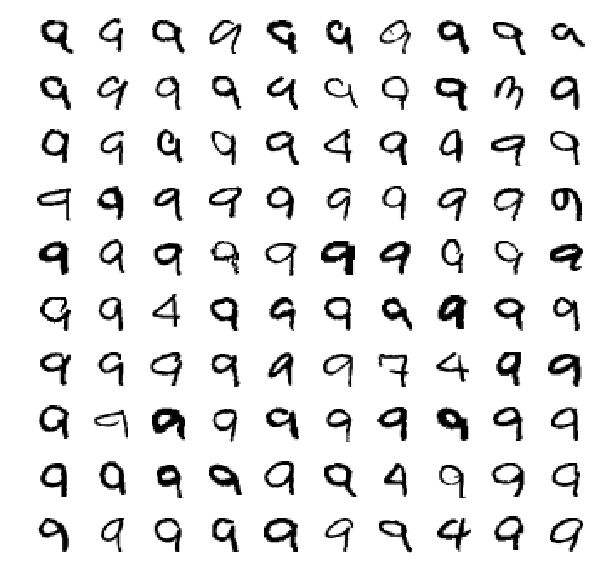

0.850 < q[:,37] <= 0.900
160


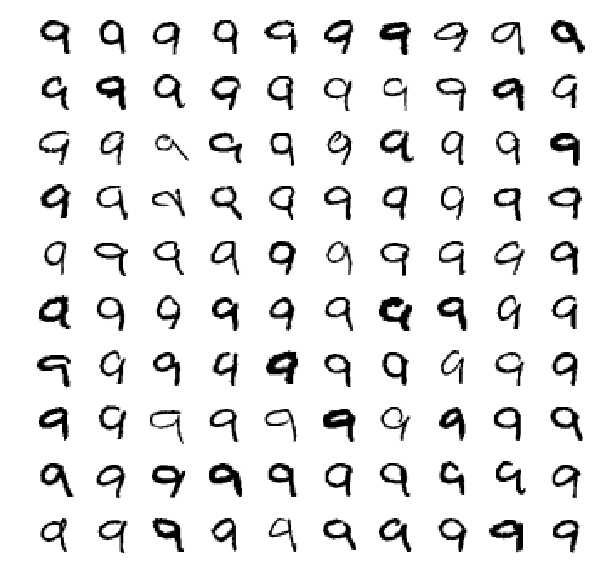

0.900 < q[:,37] <= 0.950
6


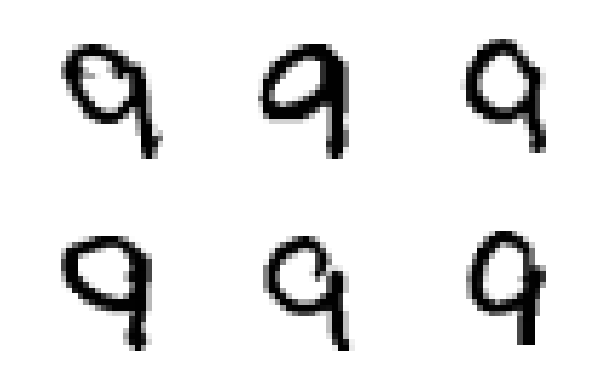

0.950 < q[:,37] <= 1.000
0


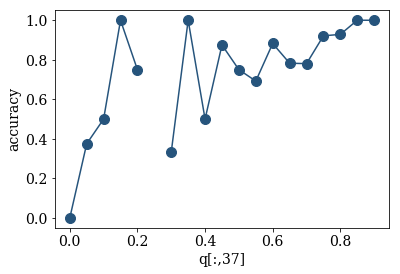

In [509]:
cluster_partitioning(37, cluster_to_label_mapping, q, y_pred, y, x, 28, step=0.05, limit=100)

## Experiment 2
### Experiment 2a - simulate querying cluster meanings
Lets calculate some statistics for each cluster (again these require knowing the labels which we won't in a real project).  We will also simulate the assignment of a label to each cluster by taking the majority cluster class for each cluster. *I am using the orignal cost function here.*

In [48]:
save_dir = '../DEC-keras/results/mnist/10'
n_clusters=10
# prepare the DEC model
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'
## passing 'kld' and None as loss to dec.initialize_model work.
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x)
dec.model.summary()
try:
  dec.load_weights(save_dir + '/DEC_model_final.h5')
  y_pred = dec.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec.clustering(x, y=y, tol=tol, maxiter=maxiter,
                          update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110.0
Trainable params: 1,665,110.0
Non-trainable params: 0.0
____________________________________________________________

In [49]:
cluster_to_label_mapping, n_assigned_list, _ = get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=10)

0 6991 8 0.942783578887
1 6924 0 0.984979780474
2 7227 7 0.969420229694
3 7418 3 0.925721218657
4 6485 4 0.518735543562
5 7717 1 0.989762861215
6 7091 2 0.955436468763
7 6221 5 0.946632374216
8 7252 9 0.505102040816
9 6674 6 0.984866646689
[8, 0, 7, 3, 4, 1, 2, 5, 9, 6]


Now lets visulaise 100 random samples from some of the clusters.  This could be what we ask citizen scientists to classify.

In [50]:
def getDimensions(n):
  dim = int(np.ceil(np.sqrt(n)))
  return (dim, dim)

In [51]:
def plotCluster(cluster_labels, cluster, X, image_dim, limit=200, cmap='gray_r'):
  indices = np.where(cluster_labels == cluster)[0] # get the examples assigned to cluster 0
  order = np.random.permutation(len(indices))
  indices = indices[order]
  n = np.where(cluster_labels == cluster)[0].shape[0]
  print(n)
  if n > limit:
    indices = indices[:limit]
    n = limit
    
  dims = getDimensions(n)
    
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dims[0],dims[1],i+1)
    ax.imshow(np.reshape(X[indices[i]], (image_dim,image_dim), order='C'), cmap=cmap)
    plt.axis('off')
  plt.show()

6485


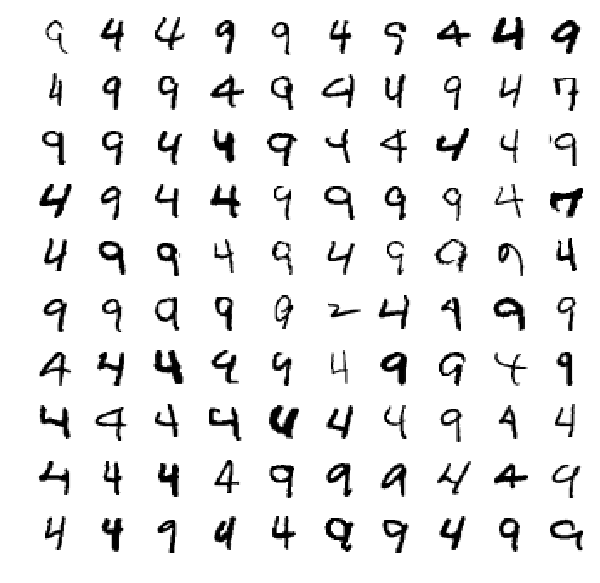

In [52]:
plotCluster(y_pred, 4, x, 28, limit=100)  # this would be a candidate to dissolve

6924


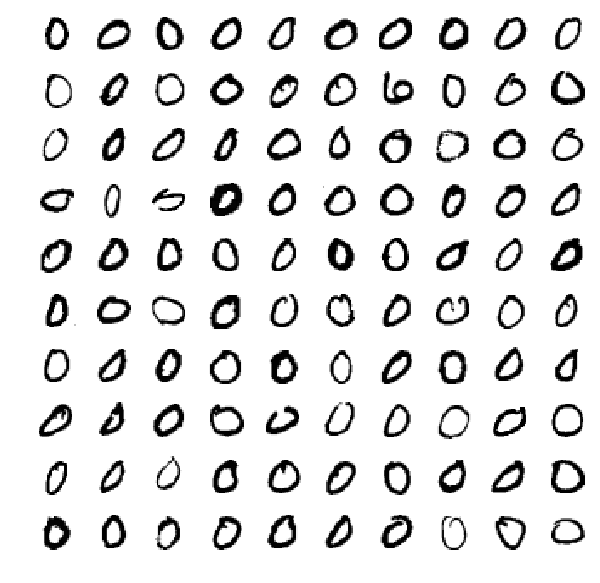

In [53]:
plotCluster(y_pred, 1, x, 28, limit=100)

7227


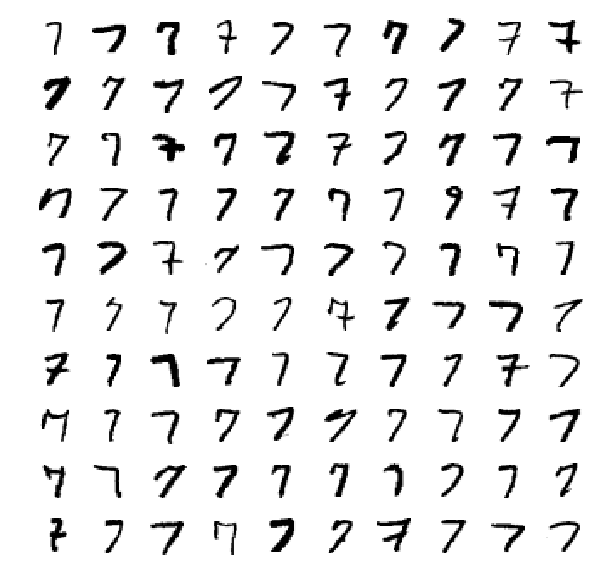

In [54]:
plotCluster(y_pred, 2, x, 28, limit=100)

Some of the clusters look pretty good and some have a mixture of classes.  So lets say we have now queried the meaning of the clusters.  I'm going to assume that the citizen scientists returned the meaning corresponding to the mjority class of each cluster.  This assumption is weakest for the clusters with a significant mixture of classes, it is unclear what 'meaning' would have been returned, but this situation could potentially be dealt with by the idea of dissolving clusters which we will experiment with later.

### Experiment 2b - design the mapping layer

I want to tag an extra layer onto our DEC model.  This layer maps the DEC outputs which are soft assignments to cluster centres (q in the paper) to softmax labels.  I assign the clusters to a label by mapping the neurons in the clustering layer to the neuron correponding to the correct label in this new output layer.  I call this a mapping layer as it just defines which neurons in the previous layers should be connected to which in the mapping layer i.e. it is not trainable.  For example if cluster 5 happens to be dominated by 2's then I map the 6th neuron in the clustering layer to the 3rd neuron in the mapping layer (indexing from 0). 

In the mapping layer I also pass the soft assignments from the clustering layer through the softmax function, but I'm not completely convinced this is needed as the assignments might be good enough for training with categorical cross entropy.

In [190]:
class MapInitializer(Initializer):
    
  def __init__(self, mapping, n_classes):
    self.mapping = mapping
    self.n_classes = n_classes

  def __call__(self, shape, dtype=None):
    return K.one_hot(self.mapping, self.n_classes)
    #return K.ones(shape=(100,10))

  def get_config(self):
    return {'mapping': self.mapping, 'n_classes': self.n_classes}

class MappingLayer(Layer):

  def __init__(self, mapping, output_dim, kernel_initializer, **kwargs):
  #def __init__(self, mapping, output_dim, **kwargs):
    self.output_dim = output_dim
    # mapping is a list where the index corresponds to a cluster and the value is the label.
    # e.g. say mapping[0] = 5, then a label of 5 has been assigned to cluster 0
    self.n_classes = np.unique(mapping).shape[0]      # get the number of classes
    self.mapping = K.variable(mapping, dtype='int32')
    self.kernel_initializer = kernel_initializer
    super(MappingLayer, self).__init__(**kwargs)

  def build(self, input_shape):
  
    self.kernel = self.add_weight(name='kernel', 
                                  shape=(input_shape[1], self.output_dim),
                                  initializer=self.kernel_initializer,
                                  trainable=True)
  
    super(MappingLayer, self).build(input_shape)  # Be sure to call this somewhere!

  def call(self, x):
    # create a matrix of zeros and ones that maps the correct neurons from the clustering layer 
    # to the output neuron corresponding to that cluster's label.
    #mapping = K.one_hot(self.mapping, self.n_classes)
    # sum up the all the soft assignments to clusters with the same labels and calculate the softmax
    # of that sum to produce a probability.
    #return K.softmax(K.dot(x, mapping))
    return K.softmax(K.dot(x, self.kernel))

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

Now we can build the model using the Keras functional API.

In [61]:
a = Input(shape=(784,)) # input layer
q = dec.model(a) # the Deep Embedding Cluster we trained above
# stick on the mapping layer, where the label is given by the majority class of a cluster
pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes)(q)
#pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, kernel_initializer=MapInitializer(cluster_to_label_mapping, 10))(q)
model = Model(inputs=a, outputs=pred)
# use categorical cross entropy as we now have a classification task
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_34 (Model)             (None, 10)                1665110   
_________________________________________________________________
mapping_layer_1 (MappingLaye (None, 10)                0         
Total params: 1,665,110.0
Trainable params: 1,665,110.0
Non-trainable params: 0.0
_________________________________________________________________


### Some sanity checking.

Before we train the network any further we can check that the new Mapping Layer is doing what I expect.  If we take the argmax of the output of this network, it will give me a predicted label in [0,9).  If I check these predictions against the true labels I should get the exact same accuracy as I got from DEC.  This only works here because the number of clusters and the number of classes are the same and because each cluster has been assigned a unique label.

In [62]:
def calculateAccuracy(model, x, y, n_classes):
  preds = model.predict(x)
  return 100*np.sum(np.argmax(preds, axis=1) == np.argmax(np_utils.to_categorical(y, n_classes), axis=1))/ len(preds)

In [63]:
preds = model.predict(x) # get the predictions of the model for each subject
print(np.argmax(preds, axis=1)) # get the argmax of the predictions i.e. the predicted label
print(y)                        # print out the true label for comparison 
print('acc:', calculateAccuracy(model, x, y, 10)) # calculate the accuracy of the model
print('acc:', cluster_acc(y, y_pred)*100) # calculate the accuracy of DEC alone

[5 0 4 ..., 9 5 6]
[5 0 4 ..., 4 5 6]
acc: 87.4085714286
acc: 87.4085714286


If the model is outputting the correct prediction then its predictions should exactly match the labels given by DEC cluster assignments.

In [65]:
# cluster assignments must be mapped to labels
print(np.all(np.argmax(preds, axis=1) == np.array(cluster_to_label_mapping)[y_pred]))

True


### Experiment 2c - simulate further trianing the network on queried labels

In this experiment I am going to assume that we have queried labels for the 60000 subjects in the MNIST training set.  I will train the model using these labels and test the performance on the 10000 subjects in thebtest set.  This simulates querying perfect classifiers for labels for ~85% of the data set and then applying the model to the remaining 15% of the data.  In reality this is really just another test of the mapping layer.

First calculate the performance of the model on the training and test sets individually so we have a benchmark.  If we can do better than these then the model is able to use the mapping layer to learn from individual labels.

In [66]:
print('training acc:', calculateAccuracy(model, x[:60000], y[:60000], 10)) # training set performance
print('test acc:', calculateAccuracy(model, x[60000:], y[60000:], 10)) # test set performance

training acc: 87.42
test acc: 87.34


In [67]:
model.fit(x[:60000], np_utils.to_categorical(y[:60000], n_classes), epochs=10, batch_size=256)

Epoch 1/10
60000/60000 [==============================] - 25s - loss: 1.5544    
Epoch 2/10
60000/60000 [==============================] - 24s - loss: 1.5206    
Epoch 3/10
60000/60000 [==============================] - 26s - loss: 1.5104    
Epoch 4/10
60000/60000 [==============================] - 24s - loss: 1.5035    
Epoch 5/10
60000/60000 [==============================] - 26s - loss: 1.4981    
Epoch 6/10
60000/60000 [==============================] - 27s - loss: 1.4947    
Epoch 7/10
60000/60000 [==============================] - 31s - loss: 1.4915    
Epoch 8/10
60000/60000 [==============================] - 30s - loss: 1.4892    
Epoch 9/10
60000/60000 [==============================] - 29s - loss: 1.4869    
Epoch 10/10
60000/60000 [==============================] - 28s - loss: 1.4861    


Calculate the performance on the training set.

In [68]:
print('training acc:', calculateAccuracy(model, x[:60000], y[:60000], 10))

training acc: 99.4883333333


Calculate the performance on the test set.  The model has "seen" these subjects during the unsupervised stage but we have not queried volunteers for their label.

In [69]:
print('test acc:', calculateAccuracy(model, x[60000:], y[60000:], 10))

test acc: 98.61


This shows that we can further train the model by using labels for individual subjects.

### Experiment 2e - number of labelled training examples

#### Random subsample (related to experiment 2f)

In [75]:
def build_model(dec, cluster_to_label_mapping, n_classes=10, input_shape=784, 
                ae_weights='../DEC-keras/results/mnist/ae_weights.h5', save_dir='../DEC-keras/results/mnist/10/',
                metrics = ['acc']):
  dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights=ae_weights,
                       x=x)
  dec.load_weights(save_dir+'/DEC_model_final.h5')
  a = Input(shape=(input_shape,)) # input layer
  q = dec.model(a)
  pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes)(q)
  model = Model(inputs=a, outputs=pred)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
  return model 

In [76]:
from keras.models import load_model
training_set_sizes = [100, 500, 1000, 5000, 10000, 25000, 60000]
m = 60000
x_test  = x[m:]
y_test  = y[m:]
accs = []
for training_set_size in training_set_sizes:
  path = '../experiments/Unsupervised_Deep_Embedding_Clustering_for_Zooniverse/experiment2e/'
  file = 'model_%d.h5'%(training_set_size)
  try:
    load_model(path+file)
  except IOError:
    model_random = build_model(dec, cluster_to_label_mapping)
    x_train = x[:training_set_size]
    y_train = y[:training_set_size]
    model_random.fit(x_train, np_utils.to_categorical(y_train), epochs=10, batch_size=256)
    model_random.save(path+file)
  accs.append(calculateAccuracy(model_random, x_test, y_test, 10))

Epoch 1/10
100/100 [==============================] - 0s - loss: 1.5797 - acc: 0.9100
Epoch 2/10
100/100 [==============================] - 0s - loss: 1.8260 - acc: 0.9100
Epoch 3/10
100/100 [==============================] - 0s - loss: 1.6447 - acc: 0.9100
Epoch 4/10
100/100 [==============================] - 0s - loss: 1.6803 - acc: 0.9100
Epoch 5/10
100/100 [==============================] - 0s - loss: 1.6762 - acc: 0.9100
Epoch 6/10
100/100 [==============================] - 0s - loss: 1.6152 - acc: 0.9100
Epoch 7/10
100/100 [==============================] - 0s - loss: 1.5929 - acc: 0.9100
Epoch 8/10
100/100 [==============================] - 0s - loss: 1.6146 - acc: 0.9100
Epoch 9/10
100/100 [==============================] - 0s - loss: 1.6072 - acc: 0.9200
Epoch 10/10
100/100 [==============================] - 0s - loss: 1.5788 - acc: 0.9200
Epoch 1/10
500/500 [==============================] - 0s - loss: 1.7286 - acc: 0.8620     
Epoch 2/10
500/500 [============================

[87.150000000000006, 91.730000000000004, 95.980000000000004, 97.189999999999998, 97.530000000000001, 98.129999999999995, 98.549999999999997]


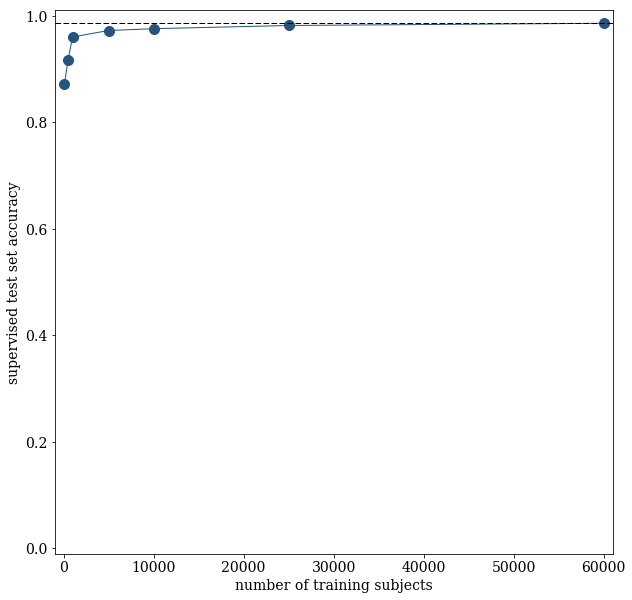

In [77]:
print(accs)
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 14
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(training_set_sizes, np.array(accs)/100., 'o', color='#26547C', ms=10)
ax.plot(training_set_sizes, np.array(accs)/100., '-', color='#26547C', lw=1)
#ax.set_xticks(training_set_sizes)
ax.plot([-1000, 61000],[0.9861, 0.9861],'k--', lw=1)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-1000,61000)
ax.set_xlabel('number of training subjects')
ax.set_ylabel('supervised test set accuracy')
plt.show()

### Experiment 2d - meaning of clusters after fine-tuning

In [266]:
x, y = load_mnist()

MNIST samples (70000, 784)


In [267]:
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=100, batch_size=batch_size)
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x, loss='kld')
dec.load_weights('../DEC-keras/results/mnist/100/DEC_model_final.h5')
dec.model.summary()
y_pred = dec.predict_clusters(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,666,010.0
Trainable params: 1,666,010.0
Non-trainable params: 0.0
____________________________________________________________

In [268]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=100)

0 82 6 0.768292682927
1 1218 1 0.995073891626
2 326 3 0.929447852761
3 923 0 0.98374864572
4 305 7 0.950819672131
5 470 7 0.874468085106
6 1624 4 0.987684729064
7 1325 5 0.972830188679
8 502 3 0.998007968127
9 1566 9 0.915070242656
10 1294 1 0.993044822257
11 1043 0 0.968360498562
12 2049 8 0.971205466081
13 950 6 0.992631578947
14 58 2 0.810344827586
15 258 2 0.848837209302
16 440 3 0.934090909091
17 1888 3 0.969809322034
18 547 4 0.946983546618
19 30 2 0.966666666667
20 984 7 0.983739837398
21 426 0 0.99765258216
22 326 5 0.858895705521
23 9 6 0.333333333333
24 404 0 0.925742574257
25 528 5 0.922348484848
26 1096 5 0.984489051095
27 1322 0 0.983358547655
28 2592 8 0.947916666667
29 56 3 0.839285714286
30 895 1 0.964245810056
31 1306 8 0.981623277182
32 899 6 0.982202447164
33 642 9 0.964174454829
34 2389 3 0.984930933445
35 15 8 0.866666666667
36 1370 6 0.989781021898
37 485 9 0.898969072165
38 1001 1 0.998001998002
39 3 8 1.0
40 1432 1 0.980446927374
41 35 2 0.571428571429
42 33 4 0

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [269]:
a = Input(shape=(784,)) # input layer
q = dec.model(a) # the Deep Embedding Cluster we trained above
# stick on the mapping layer, where the label is given by the majority class of a cluster
pred = MappingLayer(cluster_to_label_mapping, output_dim=10, kernel_initializer=MapInitializer(cluster_to_label_mapping, 10))(q)
model = Model(inputs=a, outputs=pred)
# use categorical cross entropy as we now have a classification task
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 784)               0         
_________________________________________________________________
model_130 (Model)            (None, 100)               1666010   
_________________________________________________________________
mapping_layer_19 (MappingLay (None, 10)                1000      
Total params: 1,667,010.0
Trainable params: 1,667,010.0
Non-trainable params: 0.0
_________________________________________________________________


In [270]:
model.fit(x[:25000], np_utils.to_categorical(y[:25000], 10), epochs=10, batch_size=256)

Epoch 1/10
25000/25000 [==============================] - 14s - loss: 1.6309    
Epoch 2/10
25000/25000 [==============================] - 12s - loss: 1.5042    
Epoch 3/10
25000/25000 [==============================] - 12s - loss: 1.3988    
Epoch 4/10
25000/25000 [==============================] - 13s - loss: 1.2906    
Epoch 5/10
25000/25000 [==============================] - 12s - loss: 1.1866    
Epoch 6/10
25000/25000 [==============================] - 11s - loss: 1.0934    
Epoch 7/10
25000/25000 [==============================] - 12s - loss: 1.0029    
Epoch 8/10
25000/25000 [==============================] - 11s - loss: 0.9185    
Epoch 9/10
25000/25000 [==============================] - 11s - loss: 0.8444    
Epoch 10/10
25000/25000 [==============================] - 11s - loss: 0.7741    


In [271]:
dec = model.layers[1]
print(dec.predict(x[:10]).shape)

(10, 100)


In [272]:
dec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,666,010.0
Trainable params: 1,666,010.0
Non-trainable params: 0.0
____________________________________________________________

In [273]:
y_pred = np.argmax(dec.predict(x), axis=1)

In [274]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=100)

0 41 6 0.90243902439
1 1249 1 0.991993594876
2 331 3 0.92749244713
3 965 0 0.99067357513
4 269 7 0.966542750929
5 447 7 0.903803131991
6 1691 4 0.98521584861
7 1306 5 0.982388973966
8 508 3 0.996062992126
9 1537 9 0.962914769031
10 1497 1 0.99331997328
11 1084 0 0.972324723247
12 2152 8 0.969795539033
13 944 6 0.991525423729
14 45 2 0.777777777778
15 196 2 0.862244897959
16 452 3 0.951327433628
17 1962 3 0.979612640163
18 618 4 0.959546925566
19 13 2 0.923076923077
20 1057 7 0.988647114475
21 377 0 0.997347480106
22 311 5 0.88424437299
23 1 8 1.0
24 392 0 0.966836734694
25 516 5 0.93992248062
26 1099 5 0.987261146497
27 1207 0 0.981772990886
28 2544 8 0.968160377358
29 14 3 0.714285714286
30 329 1 0.951367781155
31 1341 8 0.986577181208
32 940 6 0.981914893617
33 586 9 0.9795221843
34 2515 3 0.987673956262
35 5 8 0.8
36 1409 6 0.988644428673
37 452 9 0.955752212389
38 843 1 0.996441281139
39 0 0 nan
40 1510 1 0.986754966887
41 22 2 0.545454545455
42 11 4 0.727272727273
43 1 8 1.0
44 2 

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[  3.   0.   0.   0.   1.   0.   1.   0.   1.   2.   0.   3.   1.   1.   3.
   2.   6.   5.  13.  58.]
[  5.   0.   0.   0.   0.   0.   2.   0.   0.   0.   3.   1.   1.   1.   2.
   2.   3.   4.   6.  70.]
[0, 1, 2, 3, 5, 6, 7, 10, 12, 13, 15, 19]


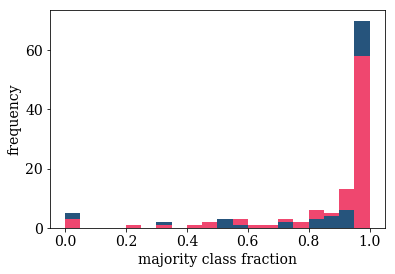

In [275]:
bins = np.arange(0,1.05,0.05)
counts_orig, _, _ = plt.hist(np.nan_to_num(majority_class_fractions_orig), bins=bins, color='#EF476F', label='original cost')
counts, _, _ = plt.hist(np.nan_to_num(majority_class_fractions), bins=bins, color='#26547C', label='updated cost')
print(counts_orig)
print(counts)
overlap = list(np.where(np.array(counts_orig) <= np.array(counts))[0])
print(overlap)
for i in range(len(overlap)):
  to_plot = [bins[overlap[i]], bins[overlap[i]+1]]
  plt.hist(np.nan_to_num(majority_class_fractions_orig), bins=to_plot, color='#EF476F')
plt.ylabel('frequency')
plt.xlabel('majority class fraction')
plt.show()

272


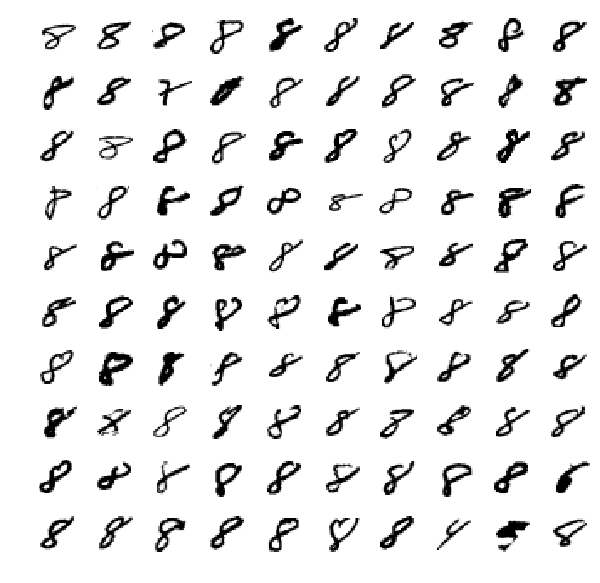

In [276]:
plotCluster(y_pred, 99, x, 28, limit=100)

40


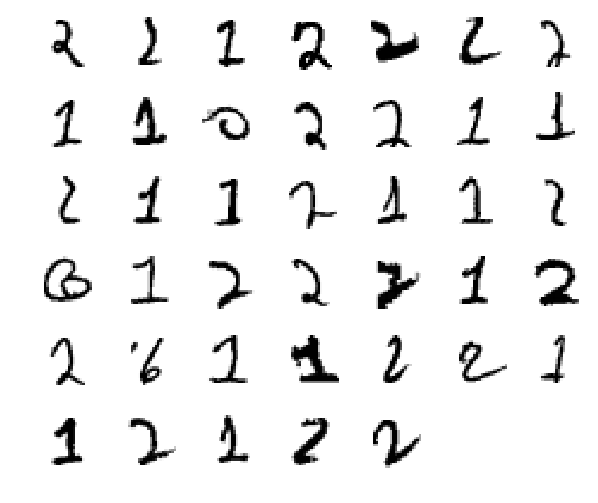

In [277]:
plotCluster(y_pred, 48, x, 28, limit=100)

1019


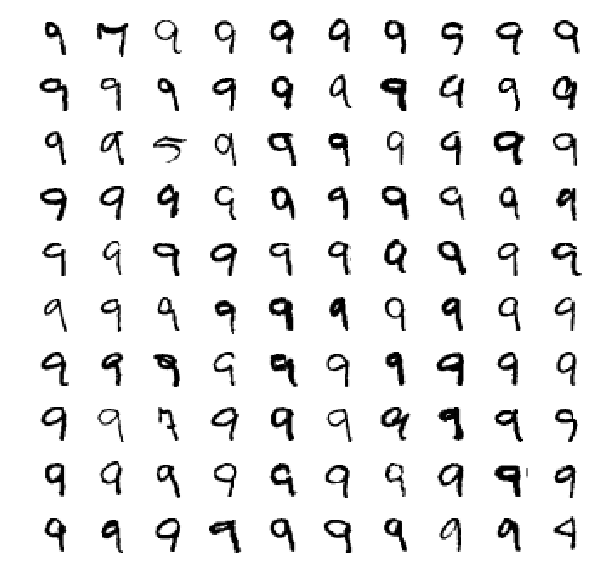

In [278]:
plotCluster(y_pred, 71, x, 28, limit=100)

## Experiment 3
### Experiment 3a - application to a real data set (Supernova Hunters)

In [314]:
data = sio.loadmat('../data/3pi_20x20_skew2_signPreserveNorm.mat')
#data = sio.loadmat('../data/3pi_20x20_skew2_zeroOneScaling.mat')
x = np.concatenate((data['X'], data['testX']))
y = np.squeeze(np.concatenate((data['y'], data['testy'])))

In [315]:
n_clusters = 10
dec_snh = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)

In [316]:
dec_snh.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                         ae_weights='../DEC-keras/results/snh/ae_weights_snh.h5', x=x)

In [317]:
dec_snh.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,473,110.0
Trainable params: 1,473,110.0
Non-trainable params: 0.0
____________________________________________________________

In [318]:
save_dir = '../DEC-keras/results/snh/10'
try:
  dec_snh.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = dec_snh.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_snh.clustering(x, y=y, tol=tol, maxiter=maxiter,
                              update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

acc: 0.611346132986


In [319]:
cluster_to_label_mapping, n_assigned_list, _ = get_cluster_to_label_mapping(y, y_pred, 2, n_clusters=10)

0 39 0 0.974358974359
1 23 0 1.0
2 8700 0 0.647356321839
3 10 0 1.0
4 286 0 0.986013986014
5 23 0 1.0
6 36 0 1.0
7 64 0 1.0
8 0 0 nan
9 38 0 1.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


39


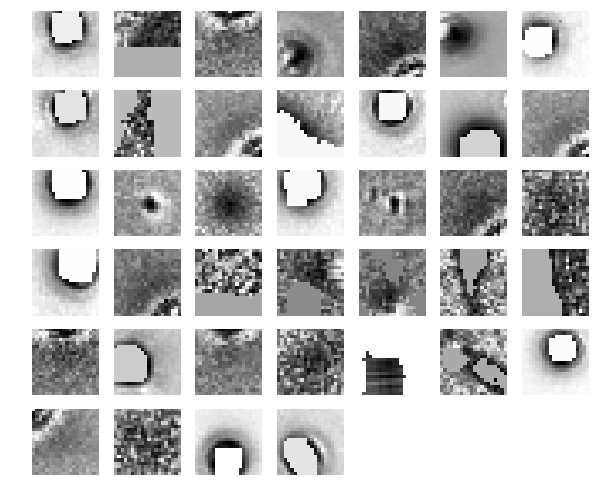

In [320]:
plotCluster(y_pred, 0, x, 20, limit=100)

23


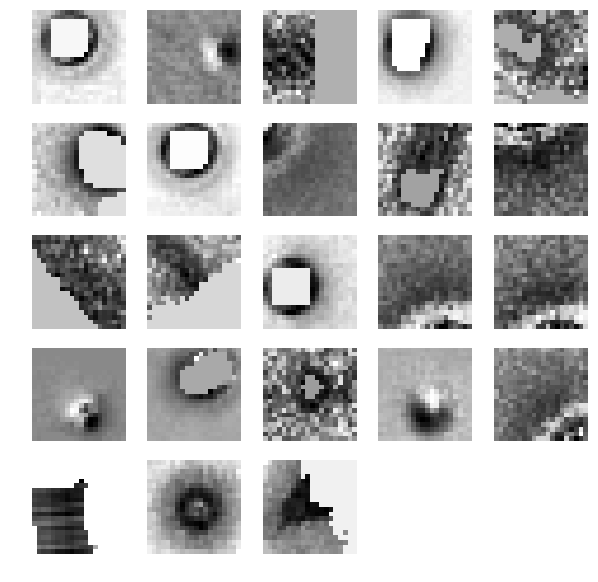

In [321]:
plotCluster(y_pred, 1, x, 20, limit=100)

286


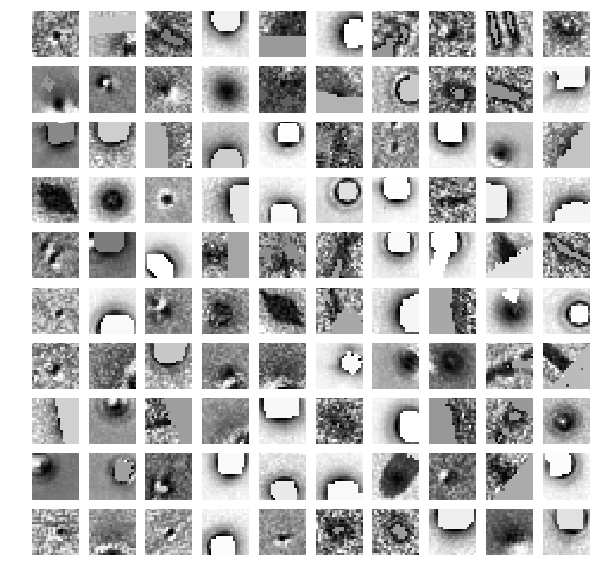

In [322]:
plotCluster(y_pred, 4, x, 20, limit=100)

8700


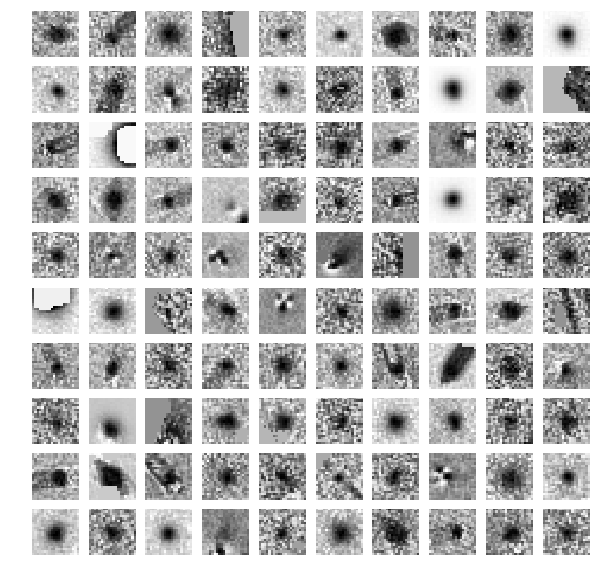

In [323]:
plotCluster(y_pred, 2, x, 20, limit=100)

#### Use new cost functions

In [324]:
save_dir = '../DEC-keras/results/testing/snh/10' # testing directory for custom loss DEC
n_clusters=10
# prepare the DEC model
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
ae_weights = '../DEC-keras/results/snh/ae_weights_snh.h5'
## passing 'kld' and None as loss to dec.initialize_model work.
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x, loss=custom_kld_with_penalty)
dec.model.summary()
try:
  dec.load_weights(save_dir + '/DEC_model_final.h5')
  y_pred = dec.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec.clustering(x, y=y, tol=tol, maxiter=maxiter,
                          update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,473,110.0
Trainable params: 1,473,110.0
Non-trainable params: 0.0
____________________________________________________________

In [325]:
cluster_to_label_mapping, n_assigned_list, _ = get_cluster_to_label_mapping(y, y_pred, 2, n_clusters=10)

0 137 0 0.985401459854
1 1176 0 0.543367346939
2 1736 0 0.773041474654
3 1218 0 0.576354679803
4 674 0 0.626112759644
5 423 0 0.990543735225
6 990 0 0.732323232323
7 937 0 0.64674493063
8 435 0 1.0
9 1493 1 0.517079705291
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


## 100 clusters

In [326]:
save_dir = '../DEC-keras/results/snh/100'
dec_snh100 = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=100, batch_size=batch_size)
dec_snh100.initialize_model(optimizer=SGD(lr=0.01, momentum=momentum),
                            ae_weights='../DEC-keras/results/snh/ae_weights_snh.h5', 
                            x=x, loss='kld')
try:
  dec_snh100.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = dec_snh100.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_snh100.clustering(x, y=y, tol=tol, maxiter=maxiter,
                                 update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

acc: 0.0984922442781


In [327]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y, y_pred, 2, n_clusters=100)

0 99 1 0.606060606061
1 11 0 1.0
2 32 0 0.90625
3 0 0 nan
4 231 1 0.679653679654
5 294 1 0.62925170068
6 391 0 0.925831202046
7 306 0 0.71568627451
8 0 0 nan
9 198 0 0.969696969697
10 698 1 0.714899713467
11 23 0 1.0
12 80 0 1.0
13 71 1 0.760563380282
14 5 0 1.0
15 269 1 0.646840148699
16 81 0 0.604938271605
17 71 0 0.985915492958
18 78 0 1.0
19 140 0 0.985714285714
20 55 0 1.0
21 52 0 0.961538461538
22 175 0 0.782857142857
23 0 0 nan
24 87 0 0.988505747126
25 80 0 1.0
26 70 0 1.0
27 74 0 1.0
28 79 0 0.974683544304
29 0 0 nan
30 14 0 1.0
31 263 0 0.520912547529
32 34 0 1.0
33 27 0 1.0
34 22 0 1.0
35 46 0 0.826086956522
36 122 0 0.532786885246
37 61 0 0.967213114754
38 480 0 0.852083333333
39 39 0 1.0
40 52 0 0.519230769231
41 294 1 0.612244897959
42 42 0 0.761904761905
43 11 0 1.0
44 1 0 1.0
45 29 0 1.0
46 24 0 1.0
47 74 0 0.986486486486
48 28 0 1.0
49 55 0 1.0
50 23 0 1.0
51 34 1 0.764705882353
52 220 1 0.645454545455
53 153 0 0.993464052288
54 40 0 0.875
55 209 1 0.626794258373
56 31

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


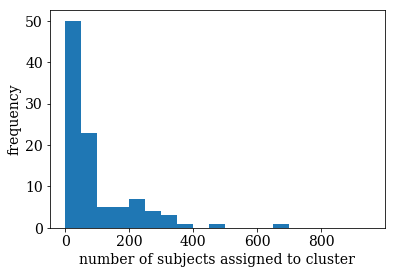

In [328]:
bins = range(0,1000,50)
counts,_,_ = plt.hist(n_assigned_list, bins=bins)
plt.ylabel('frequency')
plt.xlabel('number of subjects assigned to cluster')
plt.show()

32


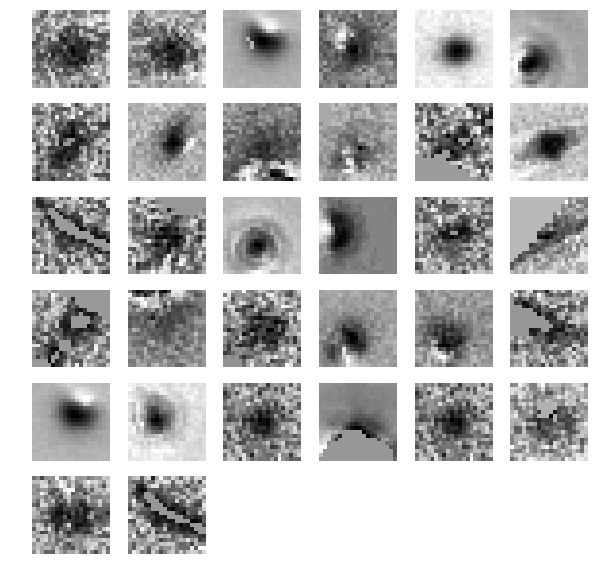

In [329]:
plotCluster(y_pred, 2, x, 20, limit=100)

215


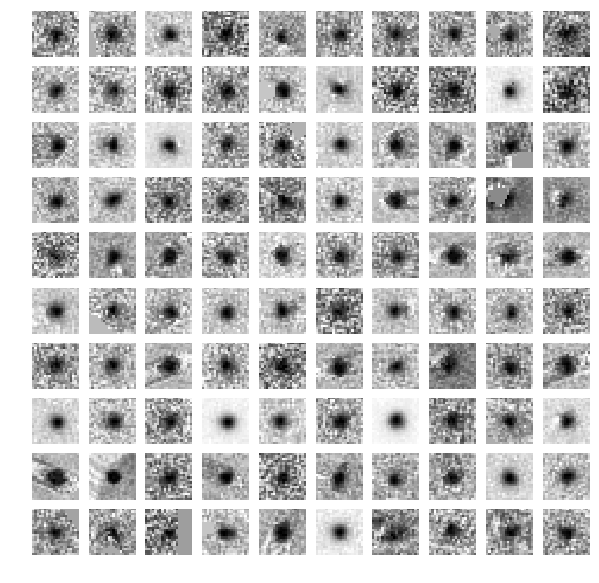

In [330]:
plotCluster(y_pred, 95, x, 20, limit=100)

698


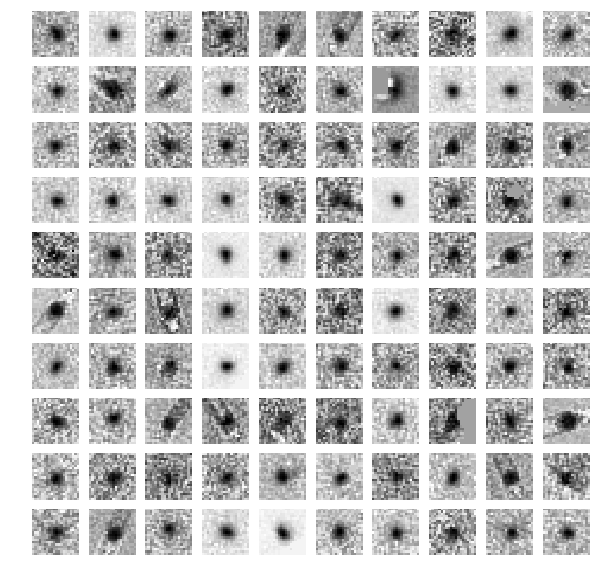

In [331]:
plotCluster(y_pred, 10, x, 20, limit=100)

#### Use new cost function

In [332]:
save_dir = '../DEC-keras/results/testing/snh/100'
dec_snh100 = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=100, batch_size=batch_size)
dec_snh100.initialize_model(optimizer=SGD(lr=0.01, momentum=momentum),
                            ae_weights='../DEC-keras/results/snh/ae_weights_snh.h5', 
                            x=x, loss=custom_kld_with_penalty)
try:
  dec_snh100.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = dec_snh100.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_snh100.clustering(x, y=y, tol=tol, maxiter=maxiter,
                                 update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

acc: 0.100227790433


In [333]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y, y_pred, 2, n_clusters=100)

0 1 0 1.0
1 167 1 0.604790419162
2 1 1 1.0
3 66 1 0.515151515152
4 7 1 0.571428571429
5 5 0 1.0
6 35 0 0.685714285714
7 77 0 0.584415584416
8 172 0 0.5
9 72 1 0.597222222222
10 52 0 0.596153846154
11 85 0 0.858823529412
12 0 0 nan
13 29 0 0.724137931034
14 90 1 0.655555555556
15 79 1 0.53164556962
16 158 0 0.613924050633
17 60 0 0.766666666667
18 113 0 0.672566371681
19 7 0 1.0
20 36 0 0.805555555556
21 99 1 0.545454545455
22 5 0 0.8
23 101 0 0.554455445545
24 52 0 0.980769230769
25 99 0 0.79797979798
26 7 0 0.857142857143
27 23 0 0.521739130435
28 59 1 0.627118644068
29 114 0 0.508771929825
30 84 0 0.690476190476
31 8 0 0.875
32 342 0 0.926900584795
33 378 0 0.738095238095
34 39 1 0.666666666667
35 103 0 0.970873786408
36 2 0 1.0
37 9 0 1.0
38 172 0 0.970930232558
39 65 0 0.615384615385
40 26 0 0.730769230769
41 51 1 0.607843137255
42 76 0 0.697368421053
43 4 0 0.5
44 125 1 0.552
45 77 1 0.571428571429
46 146 0 0.541095890411
47 212 0 0.698113207547
48 51 0 0.901960784314
49 25 0 0.8


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


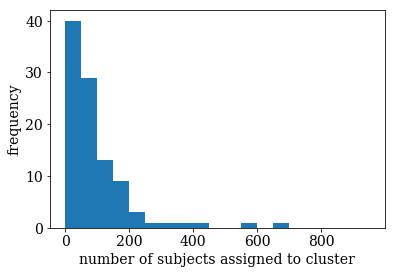

In [334]:
bins = range(0,1000,50)
counts,_,_ = plt.hist(n_assigned_list, bins=bins)
plt.ylabel('frequency')
plt.xlabel('number of subjects assigned to cluster')
plt.show()

[ 11.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.   3.   9.   2.   3.
   4.   1.   2.   3.  58.]
[  2.   0.   0.   0.   0.   0.   0.   0.   0.   0.  19.  11.  12.  12.   5.
   7.   5.   5.   5.  17.]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


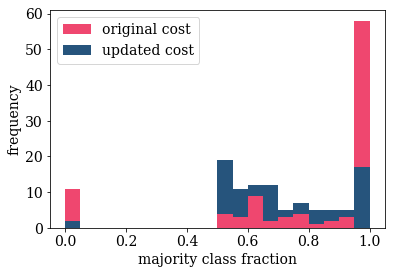

In [338]:
bins = np.arange(0,1.05,0.05)
counts_orig, _, _ = plt.hist(np.nan_to_num(majority_class_fractions_orig), bins=bins, color='#EF476F', label='original cost')
counts, _, _ = plt.hist(np.nan_to_num(majority_class_fractions), bins=bins, color='#26547C', label='updated cost')
print(counts_orig)
print(counts)
overlap = list(np.where(np.array(counts_orig) <= np.array(counts))[0])
print(overlap)
for i in range(len(overlap)):
  to_plot = [bins[overlap[i]], bins[overlap[i]+1]]
  plt.hist(np.nan_to_num(majority_class_fractions_orig), bins=to_plot, color='#EF476F')
plt.ylabel('frequency')
plt.xlabel('majority class fraction')
plt.legend(loc='upper left')
plt.show()

697


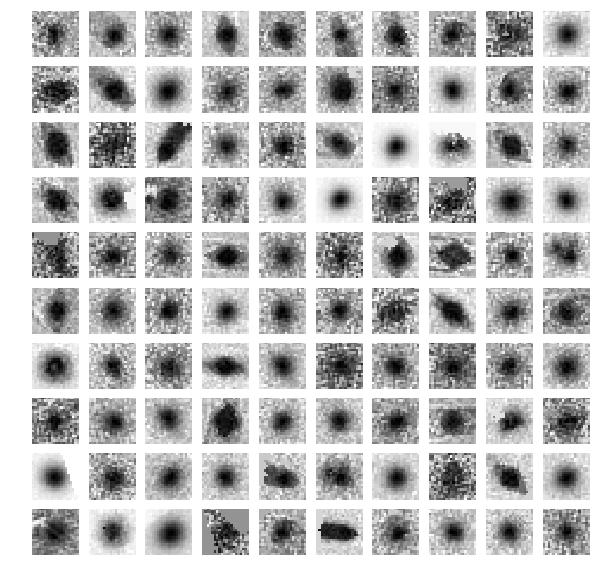

In [311]:
plotCluster(y_pred, 63, x, 20, limit=100)

598


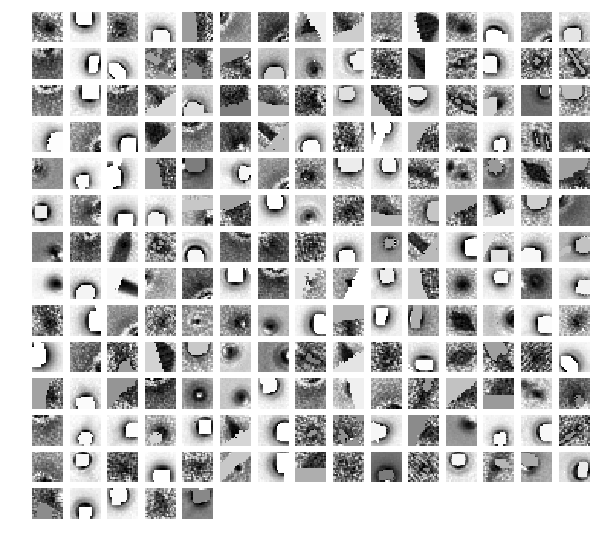

In [313]:
plotCluster(y_pred, 83, x, 20, limit=200)

## Prototyping

You can ignore everything below here.

### Mapping layer

In [151]:
def tmp(b, mapping):
  # need a zero ones matrix take dot product with input (b in this case) to sum all soft assignments of each 
  # subject to for each clusters corresponding to the same label.
  # b is mxk, there are l labels therefore the output is mxl => kxl
  # mapping is a list where the index correponds to a cluster and the value at that index is the label
  n_classes = np.unique(mapping).shape[0]
  mapping = K.one_hot(mapping, n_classes)
  #order = K.variable([4,3,2,1,0,3],dtype='int32')
  return K.softmax(K.dot(b, mapping))
  #return K.gather(b, order)

#print(K.eval(K.map_fn(tmp,a)))


In [152]:
a = K.variable([[1,2,3,4,5],[6,7,8,9,10]])
mapping = [1,0,0,1,1]
print(K.eval(tmp(a, mapping)))

[[  6.69285096e-03   9.93307173e-01]
 [  4.53978682e-05   9.99954581e-01]]


### cost function

In [155]:
save_dir = '../DEC-keras/results/snh/100'
dec_snh100 = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=100, batch_size=batch_size)
dec_snh100.initialize_model(optimizer=SGD(lr=0.01, momentum=momentum),
                            ae_weights='../DEC-keras/results/snh/ae_weights_snh.h5', x=x)
try:
  dec_snh100.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = dec_snh100.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_snh100.clustering(x, y=y, tol=tol, maxiter=maxiter,
                                 update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
print('acc:', cluster_acc(y, y_pred))

acc: 0.0984922442781


In [156]:
q = dec_snh100.model.predict(x, verbose=0)
print(q)
print(q.shape)

[[ 0.00154792  0.01451948  0.00467721 ...,  0.00568673  0.00418142
   0.0054813 ]
 [ 0.00134687  0.00548937  0.00444345 ...,  0.00430054  0.00287545
   0.00427783]
 [ 0.00175212  0.01061699  0.0040414  ...,  0.00430774  0.00549073
   0.00537648]
 ..., 
 [ 0.00317841  0.0046746   0.00942651 ...,  0.00726118  0.00540824
   0.0055943 ]
 [ 0.01265161  0.00194626  0.01285253 ...,  0.00287798  0.0051495
   0.00214467]
 [ 0.00176397  0.0039976   0.00433516 ...,  0.00419474  0.00344673
   0.00482763]]
(9219, 100)


In [157]:
ro_j = np.sum(q, axis=0) / float(q.shape[0])
print(ro_j)
print(ro_j.shape)

[ 0.01162285  0.0061593   0.00835134  0.00447125  0.01985215  0.01759335
  0.01732935  0.01870295  0.00516399  0.01293493  0.02445908  0.00487521
  0.00722649  0.02445908  0.01870295  0.02246842  0.00834909  0.00734414
  0.00796079  0.01074504  0.00608048  0.0070334   0.01130318  0.00424792
  0.00727811  0.00759082  0.00663369  0.00719098  0.00819557  0.01732935
  0.00475555  0.01903117  0.00566463  0.00510415  0.00591801  0.00758145
  0.01009086  0.00726113  0.02148223  0.00576815  0.00772302  0.01837515
  0.01130312  0.00526444  0.00479248  0.00518345  0.00482404  0.00747945
  0.00493121  0.00686924  0.00508933  0.02445908  0.01835602  0.01196127
  0.00709813  0.02023518  0.02126548  0.00827032  0.0038971   0.02148223
  0.00520651  0.00424852  0.00691534  0.01903117  0.00537135  0.01870296
  0.00621683  0.00469345  0.00832734  0.00502735  0.00564539  0.00808396
  0.0141995   0.01041635  0.00407247  0.00556133  0.00398756  0.01837177
  0.01903117  0.00474926  0.00388727  0.02181047  0

In [158]:
ro = 100 / float(q.shape[0])
print(ro)

0.010847163466753443


In [159]:
np.sum(ro*(ro/ro_j)+(1-ro)*np.log((1-ro)/(1-ro_j)))

1.5291183

In [161]:
def custom_kld(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

In [165]:
q = dec.model.predict(x, verbose=0)
p = dec.target_distribution(q)

In [166]:
K.eval(custom_kld_with_penalty(K.variable(p), K.variable(q)))

array([ 1.1510638 ,  1.15108085,  1.11481738, ...,  1.52352965,
        1.25698447,  1.20899987], dtype=float32)

In [167]:
def custom_loss(y_true, y_pred, ro, beta):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  #kld = K.sum(y_true * K.log(y_true / y_pred), axis=-1)
  kld = K.sum(y_true * K.log(y_true / y_pred))
  
  #ro = K.cast(K.tile([K.shape(y_true)[1] / K.shape(y_true)[0]], [K.shape(y_true)[1]]), 'float64')
  #ro = K.cast(K.tile([K.cast(1, 'int32') / K.shape(y_true)[0]], [K.shape(y_true)[1]]), 'float64')
  #ro = K.cast(K.tile([K.cast(1, 'int32') / 1e4], [K.shape(y_true)[1]]), 'float64')
  ro = K.cast(K.tile([ro], [K.shape(y_true)[1]]), 'float64')
  ro_j = K.cast(K.sum(y_pred, axis=0) / K.tile([K.cast(K.shape(y_true)[0], 'float32')], [K.shape(y_true)[1]]), 'float64')
    
  #penalty = K.sum((ro * K.log(ro / ro_j)) + (1. - ro) * K.log((1. - ro) / (1. - ro_j)), axis=-1)
  penalty = K.sum((ro * K.log(ro / ro_j)) + (1. - ro) * K.log((1. - ro) / (1. - ro_j)))
  return (1/K.cast(K.shape(y_true)[0], 'float32'))*(kld + beta*K.cast(penalty, 'float32'))

In [168]:
K.eval(custom_loss(K.variable(p), K.variable(q), 0.09, 1))

0.079781875

In [169]:
K.eval(custom_loss(K.variable(p), K.variable(q), 0.09, 2))

0.079798952

In [170]:
K.eval(custom_loss(K.variable(p), K.variable(q), 0.09, 10))

0.079935588

In [171]:
K.eval(custom_loss(K.variable(p), K.variable(q), 0.09, 100))

0.081472754

In [172]:
K.eval(custom_loss(K.variable(p), K.variable(q), 0.9, 1))

0.081821971

In [173]:
ros = [1e-9, 1e-6, 3e-6, 1e-4, 3e-4, 1e-2, 3e-2, 0.9, 0.9999]
cost = []
for ro in ros:
  cost.append(K.eval(custom_loss(K.variable(p), K.variable(q), ro, 1)))

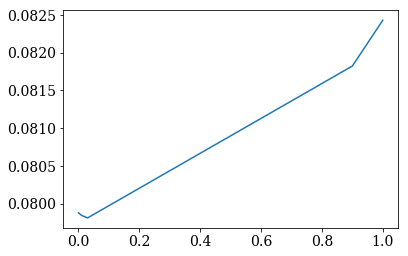

[0.079880647, 0.079880632, 0.07988061, 0.079879791, 0.079878449, 0.079845384, 0.079810955, 0.081821971, 0.082428113]


In [174]:
plt.plot(ros, cost)
plt.show()
print(cost)